# Dataset Simulation (Sanjida)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import time
import re
from google import genai

# CONFIGURATION
# Use 4 different API keys
API_KEYS = {
    "key1": "KEY1",
    "key2": "KEY2",
    "key3": "KEY3",
    "key4": "KEY4"
}

ROWS_PER_GENERATION = 250
BATCH_SIZE = 50
MODEL_NAME = "gemini-2.5-flash-lite"
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [ ]:
# HELPER FUNCTIONS
def smart_generate_batch(n_in_batch, client, model_name, max_retries=3):
    """Generate a batch with smart error handling"""
    for retry in range(max_retries):
        try:
            prompt = f"""
            Generate {n_in_batch} rows of E-COMMERCE support ticket data.
            Output ONLY CSV with header: customer_id,customer_tier,num_prev_tickets,avg_response_time_prev,issue_type,priority,ticket_text
            **MUST wrap ticket_text in DOUBLE QUOTES** if it contains commas: "text, with comma"
            Don't use any double quotes inside ticket_text

            RULES:
            1.  customer_id: 'CXXXXX' (5-digit number)
            2.  customer_tier: ['Classic', 'Silver', 'Gold', 'Platinum']
            3.  num_prev_tickets: 0-10. Gold/Platinum tiers should have HIGHER average tickets.
            4.  avg_response_time_prev: 1.0-48.0 hours. Positively correlate with num_prev_tickets.
            5.  issue_type: MUST be one of: ['Login', 'Payment', 'Delivery', 'Refund', 'Product', 'Order', 'Account', 'Other']
                - 'Login' includes: password reset, cannot login, account locked.
                - 'Account' includes: email/phone/address change.
            6.  priority: ['Low', 'Medium', 'High']. ASSIGN BASED ON THESE COMBINED RULES:
                - RULE A: If issue_type='Login' AND customer_tier='Classic' → High priority (80% chance)
                - RULE B: If issue_type='Payment' OR 'Delivery' → Increased High priority chance
                - RULE C (recurring issue): If num_prev_tickets > 3 AND avg_response_time_prev > 24 → High priority
                - RULE D: If customer_tier='Platinum' or 'Gold' → Increased High priority chance
                - Default/Otherwise: Mostly 'Medium' or 'Low'.
            7.  ticket_text: A SHORT, realistic 1-2 sentence customer message matching with other columns.
                - 'High' priority: Use urgent/angry tone ('urgent', 'asap', 'immediately', 'frustrated', 'not working', 'need this fixed today')
                - 'Medium' priority: Use concerned/neutral tone ('can you help with', 'having an issue with', 'when can this be resolved')
                - 'Low' priority: Use polite/curious tone ('just wondering', 'could you assist', 'when you have a moment')
                - For Recurring issues: Reference past issues ('this keeps happening', 'again', 'for the third time') or slow past service ('last time took days', 'still waiting on my previous ticket')
                - Login issues: Mention 'cannot login', 'locked out', 'password'

            **EXAMPLE OF CORRECT FORMAT:**
            C67890,Platinum,5,36.0,Payment,High,"Refund my $99.99 charge"

            Output ONLY CSV, no explanations.
            """

            response = client.models.generate_content(model=model_name, contents=prompt)
            csv_text = response.text.strip()

            if csv_text and "error" not in csv_text.lower():
                return csv_text

        except Exception as e:
            error_msg = str(e)
            if "429" in error_msg or "quota" in error_msg.lower():
                print(f"Quota exceeded. Stopping.")
                return None
            elif "503" in error_msg:
                wait = 10 * (retry + 1)
                print(f"Overloaded. Waiting {wait}s...")
                time.sleep(wait)
            else:
                print(f"Error: {error_msg[:100]}")
                time.sleep(5)

    return None

def parse_csv_batch(csv_text):
    """Parse CSV from Gemini response"""
    try:
        csv_text_clean = re.sub(r'^```[a-z]*\n|```$', '', csv_text, flags=re.MULTILINE).strip()
        from io import StringIO
        df = pd.read_csv(StringIO(csv_text_clean))

        # Ensure required columns
        required = ['customer_id', 'customer_tier', 'num_prev_tickets',
                   'avg_response_time_prev', 'issue_type', 'priority', 'ticket_text']

        for col in required:
            if col not in df.columns:
                df[col] = None

        return df[required]

    except Exception as e:
        print(f"    Parse error: {e}")
        return None

def add_deterministic_fields(df, start_index=0):
    """Add fields with STRICTLY chronological dates (ticket 1 = oldest, ticket 1000 = newest)"""
    df_processed = df.copy()
    n = len(df_processed)

    # 1. Sequential ticket_id
    df_processed['ticket_id'] = [f"T{i:06d}" for i in range(start_index + 1, start_index + n + 1)]

    # 2. Generate STRICTLY chronological dates
    # Calculate time span (90 days = 7776000 seconds)
    total_seconds = 90 * 24 * 60 * 60

    # Create evenly spaced timestamps
    date_list = []
    for i in range(n):
        # Calculate seconds ago for this ticket
        # Earlier tickets (lower IDs) get older dates
        seconds_ago = total_seconds - (i * total_seconds / n) + random.uniform(-3600, 3600)
        seconds_ago = max(0, min(total_seconds, seconds_ago))

        dt = datetime.now() - timedelta(seconds=seconds_ago)
        date_list.append(dt)

    # Sort to ensure perfect chronology
    date_list.sort()

    df_processed['ticket_date'] = [dt.strftime("%Y-%m-%d %H:%M:%S") for dt in date_list]

    # Final column order
    final_cols = ['ticket_id', 'ticket_date', 'customer_id',
                 'customer_tier', 'num_prev_tickets', 'avg_response_time_prev',
                 'issue_type', 'priority', 'ticket_text']

    return df_processed[final_cols]

In [ ]:
# GENERATION 1
print("STARTING GENERATION 1")
print("=" * 50)

# Create client for Key 1
client1 = genai.Client(api_key=API_KEYS["key1"])

rows_generated = 0
generation1_batches = []
batch_num = 1
start_time = time.time()

while rows_generated < ROWS_PER_GENERATION:
    rows_needed = min(BATCH_SIZE, ROWS_PER_GENERATION - rows_generated)
    print(f"Batch {batch_num}: Requesting {rows_needed} rows...")

    # Get batch
    csv_text = smart_generate_batch(rows_needed, client1, MODEL_NAME)

    if not csv_text:
        if "quota" in str(csv_text).lower() or "429" in str(csv_text):
            print("QUOTA EXHAUSTED for Key 1. Stopping Generation 1.")
            break
        print("   API call failed, retrying in 5s...")
        time.sleep(5)
        continue

    # Parse
    df_batch = parse_csv_batch(csv_text)

    if df_batch is not None and not df_batch.empty:
        generation1_batches.append(df_batch)
        rows_generated += len(df_batch)
        elapsed = time.time() - start_time
        print(f"Got {len(df_batch)} rows. Total: {rows_generated}/{ROWS_PER_GENERATION} ({elapsed:.1f}s)")
    else:
        print("   Failed to parse, retrying...")
        time.sleep(3)
        continue

    # Rate limiting
    time.sleep(4)
    batch_num += 1

# Process and save Generation 1
if generation1_batches:
    gen1_df = pd.concat(generation1_batches, ignore_index=True).head(ROWS_PER_GENERATION)
    gen1_processed = add_deterministic_fields(gen1_df, 0)

    # Save to variable AND file
    globals()["generation1_df"] = gen1_processed
    gen1_processed.to_csv("generation1_tickets.csv", index=False)

    print(f"\nGENERATION 1 COMPLETE!")
    print(f"   Rows: {len(gen1_processed)}")
    print(f"   Saved to: generation1_tickets.csv")
    print(f"   Priority distribution:\n{gen1_processed['priority'].value_counts()}")
else:
    print("\nGENERATION 1 FAILED or stopped early.")
    print("   Check API key or try again tomorrow.")

STARTING GENERATION 1
Batch 1: Requesting 50 rows...
Got 52 rows. Total: 52/250 (8.5s)
Batch 2: Requesting 50 rows...
Overloaded. Waiting 20s...
Got 51 rows. Total: 103/250 (55.6s)
Batch 3: Requesting 50 rows...
Got 51 rows. Total: 154/250 (67.5s)
Batch 4: Requesting 50 rows...
Got 51 rows. Total: 205/250 (80.4s)
Batch 5: Requesting 45 rows...
Overloaded. Waiting 10s...
Got 45 rows. Total: 250/250 (103.5s)

GENERATION 1 COMPLETE!
   Rows: 250
   Saved to: generation1_tickets.csv
   Priority distribution:
priority
High      114
Medium     92
Low        44
Name: count, dtype: int64


In [ ]:
# GENERATION 2
print("\n" + "=" * 50)
print("STARTING GENERATION 2")
print("=" * 50)

# Create client for Key 2
client2 = genai.Client(api_key=API_KEYS["key2"])

rows_generated = 0
generation2_batches = []
batch_num = 1
start_time = time.time()

# Start ticket index where Gen1 left off
start_index = len(generation1_df) if 'generation1_df' in globals() else 0

while rows_generated < ROWS_PER_GENERATION:
    rows_needed = min(BATCH_SIZE, ROWS_PER_GENERATION - rows_generated)
    print(f"Batch {batch_num}: Requesting {rows_needed} rows...")

    csv_text = smart_generate_batch(rows_needed, client2, MODEL_NAME)

    if not csv_text:
        if "quota" in str(csv_text).lower() or "429" in str(csv_text):
            print("QUOTA EXHAUSTED for Key 2. Stopping Generation 2.")
            break
        print("   API call failed, retrying in 5s...")
        time.sleep(5)
        continue

    df_batch = parse_csv_batch(csv_text)

    if df_batch is not None and not df_batch.empty:
        generation2_batches.append(df_batch)
        rows_generated += len(df_batch)
        elapsed = time.time() - start_time
        print(f"Got {len(df_batch)} rows. Total: {rows_generated}/{ROWS_PER_GENERATION} ({elapsed:.1f}s)")
    else:
        print("   Failed to parse, retrying...")
        time.sleep(3)
        continue

    time.sleep(4)
    batch_num += 1

# Process and save Generation 2
if generation2_batches:
    gen2_df = pd.concat(generation2_batches, ignore_index=True).head(ROWS_PER_GENERATION)
    gen2_processed = add_deterministic_fields(gen2_df, start_index)

    # Save to variable AND file
    globals()["generation2_df"] = gen2_processed
    gen2_processed.to_csv("generation2_tickets.csv", index=False)

    print(f"\nGENERATION 2 COMPLETE!")
    print(f"   Rows: {len(gen2_processed)}")
    print(f"   Saved to: generation2_tickets.csv")
    print(f"   Priority distribution:\n{gen2_processed['priority'].value_counts()}")

    # Show combined progress
    if 'generation1_df' in globals():
        total = len(generation1_df) + len(gen2_processed)
        print(f"\nTOTAL PROGRESS: {total}/1000 rows ({total/10}%)")
else:
    print("\nGENERATION 2 FAILED or stopped early.")


STARTING GENERATION 2
Batch 1: Requesting 50 rows...
Got 51 rows. Total: 51/250 (17.1s)
Batch 2: Requesting 50 rows...
Got 50 rows. Total: 101/250 (48.0s)
Batch 3: Requesting 50 rows...
Got 50 rows. Total: 151/250 (62.5s)
Batch 4: Requesting 50 rows...
Got 51 rows. Total: 202/250 (75.1s)
Batch 5: Requesting 48 rows...
Got 50 rows. Total: 252/250 (88.3s)

GENERATION 2 COMPLETE!
   Rows: 250
   Saved to: generation2_tickets.csv
   Priority distribution:
priority
High      120
Medium     87
Low        43
Name: count, dtype: int64

TOTAL PROGRESS: 500/1000 rows (50.0%)


In [ ]:
# GENERATION 3
print("\n" + "=" * 50)
print("STARTING GENERATION 3")
print("=" * 50)
print("NOTE: Run this cell TOMORROW if Keys 1 & 2 exhausted quotas today.")

# Create client for Key 3
client3 = genai.Client(api_key=API_KEYS["key3"])

rows_generated = 0
generation3_batches = []
batch_num = 1
start_time = time.time()

# Calculate start index based on previous generations
start_index = 0
if 'generation2_df' in globals():
    start_index = len(generation1_df) + len(generation2_df)
elif 'generation1_df' in globals():
    start_index = len(generation1_df)

while rows_generated < ROWS_PER_GENERATION:
    rows_needed = min(BATCH_SIZE, ROWS_PER_GENERATION - rows_generated)
    print(f"Batch {batch_num}: Requesting {rows_needed} rows...")

    csv_text = smart_generate_batch(rows_needed, client3, MODEL_NAME)

    if not csv_text:
        if "quota" in str(csv_text).lower() or "429" in str(csv_text):
            print("QUOTA EXHAUSTED for Key 3. Stopping Generation 3.")
            print("   Wait 24 hours and try again tomorrow.")
            break
        print("   API call failed, retrying in 5s...")
        time.sleep(5)
        continue

    df_batch = parse_csv_batch(csv_text)

    if df_batch is not None and not df_batch.empty:
        generation3_batches.append(df_batch)
        rows_generated += len(df_batch)
        elapsed = time.time() - start_time
        print(f"Got {len(df_batch)} rows. Total: {rows_generated}/{ROWS_PER_GENERATION} ({elapsed:.1f}s)")
    else:
        print("   Failed to parse, retrying...")
        time.sleep(3)
        continue

    time.sleep(4)
    batch_num += 1

# Process and save Generation 3
if generation3_batches:
    gen3_df = pd.concat(generation3_batches, ignore_index=True).head(ROWS_PER_GENERATION)
    gen3_processed = add_deterministic_fields(gen3_df, start_index)

    globals()["generation3_df"] = gen3_processed
    gen3_processed.to_csv("generation3_tickets.csv", index=False)

    print(f"\nGENERATION 3 COMPLETE!")
    print(f"   Rows: {len(gen3_processed)}")
    print(f"   Saved to: generation3_tickets.csv")
else:
    print("\nGENERATION 3 FAILED or stopped early.")


STARTING GENERATION 3
NOTE: Run this cell TOMORROW if Keys 1 & 2 exhausted quotas today.
Batch 1: Requesting 50 rows...
Got 51 rows. Total: 51/250 (25.4s)
Batch 2: Requesting 50 rows...
Got 51 rows. Total: 102/250 (39.1s)
Batch 3: Requesting 50 rows...
Got 51 rows. Total: 153/250 (62.0s)
Batch 4: Requesting 50 rows...
Got 51 rows. Total: 204/250 (75.0s)
Batch 5: Requesting 46 rows...
Got 47 rows. Total: 251/250 (95.6s)

GENERATION 3 COMPLETE!
   Rows: 250
   Saved to: generation3_tickets.csv


In [ ]:
# GENERATION 4
print("\n" + "=" * 50)
print("STARTING GENERATION 4")
print("=" * 50)

# Create client for Key 4
client4 = genai.Client(api_key=API_KEYS["key4"])

rows_generated = 0
generation4_batches = []
batch_num = 1
start_time = time.time()

# Calculate start index based on previous generations
start_index = 0
if 'generation3_df' in globals():
    start_index = len(generation1_df) + len(generation2_df) + len(generation3_df)
elif 'generation2_df' in globals():
    start_index = len(generation1_df) + len(generation2_df)
elif 'generation1_df' in globals():
    start_index = len(generation1_df)

while rows_generated < ROWS_PER_GENERATION:
    rows_needed = min(BATCH_SIZE, ROWS_PER_GENERATION - rows_generated)
    print(f"Batch {batch_num}: Requesting {rows_needed} rows...")

    csv_text = smart_generate_batch(rows_needed, client4, MODEL_NAME)

    if not csv_text:
        if "quota" in str(csv_text).lower() or "429" in str(csv_text):
            print("QUOTA EXHAUSTED for Key 4. Stopping Generation 4.")
            print("   All keys exhausted. Wait 24 hours.")
            break
        print("   API call failed, retrying in 5s...")
        time.sleep(5)
        continue

    df_batch = parse_csv_batch(csv_text)

    if df_batch is not None and not df_batch.empty:
        generation4_batches.append(df_batch)
        rows_generated += len(df_batch)
        elapsed = time.time() - start_time
        print(f"Got {len(df_batch)} rows. Total: {rows_generated}/{ROWS_PER_GENERATION} ({elapsed:.1f}s)")
    else:
        print("   Failed to parse, retrying...")
        time.sleep(3)
        continue

    time.sleep(4)
    batch_num += 1

# Process and save Generation 4
if generation4_batches:
    gen4_df = pd.concat(generation4_batches, ignore_index=True).head(ROWS_PER_GENERATION)
    gen4_processed = add_deterministic_fields(gen4_df, start_index)

    globals()["generation4_df"] = gen4_processed
    gen4_processed.to_csv("generation4_tickets.csv", index=False)

    print(f"\nGENERATION 4 COMPLETE!")
    print(f"   Rows: {len(gen4_processed)}")
    print(f"   Saved to: generation4_tickets.csv")
else:
    print("\nGENERATION 4 FAILED or stopped early.")


STARTING GENERATION 4
Batch 1: Requesting 50 rows...
Got 51 rows. Total: 51/250 (18.9s)
Batch 2: Requesting 50 rows...
Got 51 rows. Total: 102/250 (52.3s)
Batch 3: Requesting 50 rows...
Got 51 rows. Total: 153/250 (64.7s)
Batch 4: Requesting 50 rows...
   API call failed, retrying in 5s...
Batch 4: Requesting 50 rows...
   API call failed, retrying in 5s...
Batch 4: Requesting 50 rows...
Got 52 rows. Total: 205/250 (147.3s)
Batch 5: Requesting 45 rows...
   API call failed, retrying in 5s...
Batch 5: Requesting 45 rows...
Got 45 rows. Total: 250/250 (188.3s)

GENERATION 4 COMPLETE!
   Rows: 250
   Saved to: generation4_tickets.csv


In [ ]:
# COMBINE ALL GENERATIONS
print("COMBINING ALL AVAILABLE GENERATIONS")
print("=" * 50)

# List all generation DataFrames that exist
available_generations = []
for i in range(1, 5):
    df_name = f"generation{i}_df"
    if df_name in globals():
        available_generations.append(globals()[df_name])
        print(f"Found {df_name}: {len(globals()[df_name])} rows")

if available_generations:
    # Combine all available generations
    df_final = pd.concat(available_generations, ignore_index=True)

    # Re-sort by ticket_id to ensure proper order
    df_final = df_final.sort_values('ticket_id').reset_index(drop=True)

    # Save final combined dataset
    df_final.to_csv("final_combined_tickets.csv", index=False)

    print(f"\nFINAL DATASET CREATED!")
    print(f"   Total rows: {len(df_final)}")
    print(f"   File: final_combined_tickets.csv")

    print(f"\nFINAL STATISTICS:")
    print(f"   Missing values: {df_final.isna().sum().sum()}")
    print(f"   Priority distribution:\n{df_final['priority'].value_counts()}")
    print(f"   Customer tiers:\n{df_final['customer_tier'].value_counts()}")

    print("\nFirst 3 rows:")
    print(df_final.head(3).to_string(index=False))

else:
    print("No generations found. Run at least Generation 1 first.")

COMBINING ALL AVAILABLE GENERATIONS
Found generation1_df: 250 rows
Found generation2_df: 250 rows
Found generation3_df: 250 rows
Found generation4_df: 250 rows

FINAL DATASET CREATED!
   Total rows: 1000
   File: final_combined_tickets.csv

FINAL STATISTICS:
   Missing values: 0
   Priority distribution:
priority
High      457
Medium    359
Low       184
Name: count, dtype: int64
   Customer tiers:
customer_tier
Classic     256
Silver      254
Gold        251
Platinum    239
Name: count, dtype: int64

First 3 rows:
ticket_id         ticket_date customer_id customer_tier  num_prev_tickets  avg_response_time_prev issue_type priority                                                              ticket_text
  T000001 2025-10-21 16:14:17      C12345       Classic                 2                    15.5      Login     High              I cannot login to my account, it says my password is wrong.
  T000002 2025-10-22 01:49:41      C67890        Silver                 4                    22.1

In [ ]:
OUTPUT_FILENAME = "synthetic_tickets.csv"

# Create a COPY for missing value injection
print("\n" + "=" * 60)
print("INJECTING MISSING VALUES (MCAR, MAR, MNAR)")
print("=" * 60)

df_with_missing = df_final.copy()
n = len(df_with_missing)

# 1. MCAR (5% random missing in safe columns)
mcar_cols = ['customer_tier', 'num_prev_tickets', 'avg_response_time_prev', 'issue_type']
for col in mcar_cols:
    if col in df_with_missing.columns:
        mask = np.random.rand(n) < 0.02
        df_with_missing.loc[mask, col] = np.nan
        print(f"   MCAR: {mask.sum():3d} values missing in '{col}'")

# 2. MAR: 'avg_response_time_prev' & 'num_prev_tickets' missing more for 'Classic' tier
classic_mask = df_with_missing['customer_tier'] == 'Classic'
df_with_missing.loc[classic_mask & (np.random.rand(n) < 0.025), 'avg_response_time_prev'] = np.nan
df_with_missing.loc[classic_mask & (np.random.rand(n) < 0.025), 'num_prev_tickets'] = np.nan
print(f"   MAR: {classic_mask.sum()} Classic tier avg_response_time_prev & num_prev_tickets missing")

# 3. MNAR: VERY SLOW responses (>48h) are "forgotten" (not logged)
if 'avg_response_time_prev' in df_with_missing.columns:
    mnar_slow_mask = df_with_missing['avg_response_time_prev'] > 48
    df_with_missing.loc[mnar_slow_mask, 'avg_response_time_prev'] = np.nan
    print(f"   MNAR: {mnar_slow_mask.sum():3d} very slow responses (>48h) 'forgotten'")

# Save the version WITH missing values
df_with_missing.to_csv(OUTPUT_FILENAME, index=False)

# VALIDATION & SUMMARY
print("\n" + "=" * 60)
print("DATASET GENERATION COMPLETE!")
print(f"   Missing version (for modeling): {OUTPUT_FILENAME}")
print(f"   Rows: {len(df_with_missing)}, Columns: {len(df_with_missing.columns)}")

print("\nMISSING VALUES SUMMARY:")
missing_summary = df_with_missing.isna().sum()
missing_summary = missing_summary[missing_summary > 0]  # Only show columns with missing
if len(missing_summary) > 0:
    for col, count in missing_summary.items():
        pct = (count / len(df_with_missing)) * 100
        print(f"   {col}: {count:3d} missing ({pct:.1f}%)")
else:
    print("   No missing values found (unexpected!)")

print("\nSAMPLE ROWS (with potential missing values):")
print(df_with_missing.head(3).to_string(index=False))


INJECTING MISSING VALUES (MCAR, MAR, MNAR)
   MCAR:  22 values missing in 'customer_tier'
   MCAR:  16 values missing in 'num_prev_tickets'
   MCAR:  20 values missing in 'avg_response_time_prev'
   MCAR:  13 values missing in 'issue_type'
   MAR: 252 Classic tier avg_response_time_prev & num_prev_tickets missing
   MNAR:   0 very slow responses (>48h) 'forgotten'

DATASET GENERATION COMPLETE!
   Missing version (for modeling): synthetic_tickets.csv
   Rows: 1000, Columns: 9

MISSING VALUES SUMMARY:
   customer_tier:  22 missing (2.2%)
   num_prev_tickets:  19 missing (1.9%)
   avg_response_time_prev:  30 missing (3.0%)
   issue_type:  13 missing (1.3%)

SAMPLE ROWS (with potential missing values):
ticket_id         ticket_date customer_id customer_tier  num_prev_tickets  avg_response_time_prev issue_type priority                                                              ticket_text
  T000001 2025-10-21 16:14:17      C12345       Classic               2.0                    15.5   

# Load Synthetic Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving synthetic_tickets.csv to synthetic_tickets.csv


In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv('synthetic_tickets.csv')

# Preview the data
df.head()

,ticket_id,ticket_date,customer_id,customer_tier,num_prev_tickets,avg_response_time_prev,issue_type,ticket_text,priority
0,T000001,21/10/2025 16:14,C12345,Classic,2.0,15.5,Login,"I cannot login to my account, it says my passw...",High
1,T000002,22/10/2025 1:49,C67890,Silver,4.0,22.1,Payment,My credit card was charged twice for the same ...,Medium
2,T000003,22/10/2025 9:58,C11223,Gold,7.0,30.2,Delivery,"My package has not arrived yet, it was suppose...",High
3,T000004,22/10/2025 18:42,C44556,Platinum,9.0,45.0,Refund,I need a refund for a product that arrived bro...,High
4,T000005,23/10/2025 2:19,C77889,Classic,1.0,8.0,Product,I have a question about the product specificat...,Low


# Simple EDA (Sanjida)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime

# Basic structure
print("DATASET EXPLORATORY DATA ANALYSIS")
print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nDataset structure:")
df.info()

DATASET EXPLORATORY DATA ANALYSIS
Dataset size: 1000 rows, 9 columns

Dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ticket_id               1000 non-null   object 
 1   ticket_date             1000 non-null   object 
 2   customer_id             1000 non-null   object 
 3   customer_tier           978 non-null    object 
 4   num_prev_tickets        981 non-null    float64
 5   avg_response_time_prev  970 non-null    float64
 6   issue_type              987 non-null    object 
 7   ticket_text             1000 non-null   object 
 8   priority                1000 non-null   object 
dtypes: float64(2), object(7)
memory usage: 70.4+ KB


In [ ]:
# Missing values
print("MISSING VALUES ANALYSIS")

df_neutral = df.copy()

# Step 1: Diagnose missing patterns
print("1. DIAGNOSE Missing Patterns:")
missing_by_col = df_neutral.isnull().sum()
missing_pct = (missing_by_col / len(df_neutral)) * 100

# Only impute columns with <30% missing (standard threshold)
cols_to_impute = missing_by_col[(missing_pct > 0) & (missing_pct < 30)].index.tolist()
print(f"   Columns with <30% missing (will impute): {cols_to_impute}")

# Step 2: Check for obvious MAR patterns
print("\n2. CHECK for Missing-At-Random Patterns:")

mar_checks = []
if 'customer_tier' in df_neutral.columns:
    # Check if missingness differs by customer tier
    for col in ['avg_response_time_prev', 'num_prev_tickets']:
        if col in df_neutral.columns:
            missing_by_tier = df_neutral.groupby('customer_tier')[col].agg(
                lambda x: x.isna().mean()
            )
            max_diff = missing_by_tier.max() - missing_by_tier.min()

            if max_diff > 0.05:  # Threshold: 5% difference
                mar_checks.append((col, f"Missingness varies by customer_tier (diff: {max_diff:.1%})"))
                print(f"     {col}: Missingness varies by customer_tier ({max_diff:.1%} difference)")
            else:
                print(f"    {col}: Missingness consistent across tiers")

# Step 3: SMART imputation
print("\n3. APPLY Smart Imputation:")

for col in cols_to_impute:
    if df_neutral[col].dtype in ['int64', 'float64']:
        # Check skewness to choose imputation method
        from scipy import stats

        # Use non-missing values to check distribution
        non_missing = df_neutral[col].dropna()

        if len(non_missing) > 10:  # Enough data to check
            skewness = abs(stats.skew(non_missing))

            if skewness > 1:  # Highly skewed, use median
                impute_value = non_missing.median()
                method = f"median (skewness: {skewness:.2f})"
            else:  # Not too skewed, use mean
                impute_value = non_missing.mean()
                method = f"mean (skewness: {skewness:.2f})"
        else:
            impute_value = df_neutral[col].median()
            method = "median (insufficient data)"

        # Format the impute value based on column type
        if col == 'num_prev_tickets':
            # Round to nearest whole number for ticket counts
            impute_value = int(round(impute_value))
            method += " --> rounded to whole number"
        elif col == 'avg_response_time_prev':
            # Round to 1 decimal place for response time
            impute_value = round(impute_value, 1)
            method += " --> rounded to 1 decimal"

        # Apply imputation
        missing_count = df_neutral[col].isna().sum()
        df_neutral[col] = df_neutral[col].fillna(impute_value)

        print(f"   {col}: Numerical --> {method}, imputed {missing_count} values")

    elif df_neutral[col].dtype == 'object':
        # For categorical/text: Check if it's a true category or free text
        unique_count = df_neutral[col].nunique()

        if unique_count < 20 and unique_count > 1:  # Reasonable categorical
            # Use mode (most frequent)
            mode_val = df_neutral[col].mode()
            impute_value = mode_val[0] if not mode_val.empty else "Unknown"
            method = "mode (categorical)"
        else:  # Free text or high-cardinality
            # Create flag instead of imputing bad text
            df_neutral[f"{col}_was_missing"] = df_neutral[col].isna().astype(int)
            impute_value = "Not provided"
            method = "placeholder + flag created"

        missing_count = df_neutral[col].isna().sum()
        df_neutral[col] = df_neutral[col].fillna(impute_value)

        print(f"   {col}: Categorical --> {method}, imputed {missing_count} values")

# Step 4: Final cleanup
print("\n4. FINAL Cleanup:")
print(f"\nMissing values handling complete.")
print("\n   Missing values count:")
df_neutral.isnull().sum()

MISSING VALUES ANALYSIS
1. DIAGNOSE Missing Patterns:
   Columns with <30% missing (will impute): ['customer_tier', 'num_prev_tickets', 'avg_response_time_prev', 'issue_type']

2. CHECK for Missing-At-Random Patterns:
    avg_response_time_prev: Missingness consistent across tiers
    num_prev_tickets: Missingness consistent across tiers

3. APPLY Smart Imputation:
   customer_tier: Categorical --> mode (categorical), imputed 22 values
   num_prev_tickets: Numerical --> mean (skewness: 0.13) --> rounded to whole number, imputed 19 values
   avg_response_time_prev: Numerical --> mean (skewness: 0.03) --> rounded to 1 decimal, imputed 30 values
   issue_type: Categorical --> mode (categorical), imputed 13 values

4. FINAL Cleanup:

Missing values handling complete.

   Missing values count:


,0
ticket_id,0
ticket_date,0
customer_id,0
customer_tier,0
num_prev_tickets,0
avg_response_time_prev,0
issue_type,0
ticket_text,0
priority,0


TARGET VARIABLE: PRIORITY DISTRIBUTION
Priority distribution:
  High: 457 tickets (45.7%)
  Medium: 359 tickets (35.9%)
  Low: 184 tickets (18.4%)


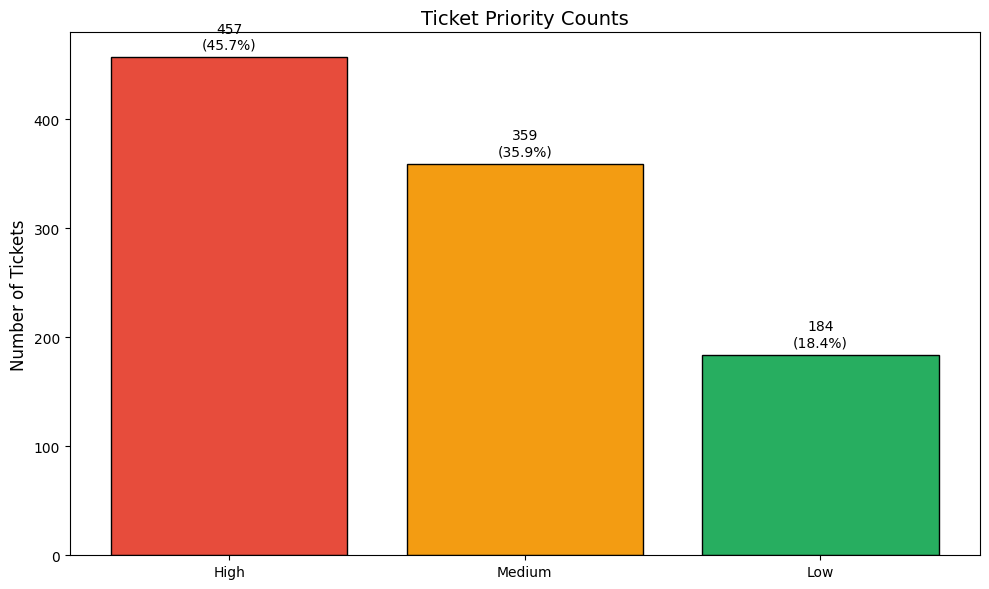

In [ ]:
# Reassign df to the cleaned version
df = df_neutral.copy()
# Target variable distribution
print("TARGET VARIABLE: PRIORITY DISTRIBUTION")

priority_counts = df['priority'].value_counts()
priority_pct = df['priority'].value_counts(normalize=True) * 100

print("Priority distribution:")
for priority in ['High', 'Medium', 'Low']:
    if priority in priority_counts.index:
        count = priority_counts[priority]
        pct = priority_pct[priority]
        print(f"  {priority}: {count} tickets ({pct:.1f}%)")

# Priority distribution visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))  # Single plot

# Bar chart
colors = {'High': '#e74c3c', 'Medium': '#f39c12', 'Low': '#27ae60'}
bar_colors = [colors.get(p, 'gray') for p in priority_counts.index]
bars = ax.bar(priority_counts.index, priority_counts.values, color=bar_colors, edgecolor='black')
ax.set_title('Ticket Priority Counts', fontsize=14)
ax.set_ylabel('Number of Tickets', fontsize=12)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{height}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

CORRELATION HEATMAP

Features in correlation matrix:
  Prev Tickets: num_prev_tickets
  Avg Response Time: avg_response_time_prev
  Customer Tier: customer_tier_encoded
  PRIORITY: priority_encoded


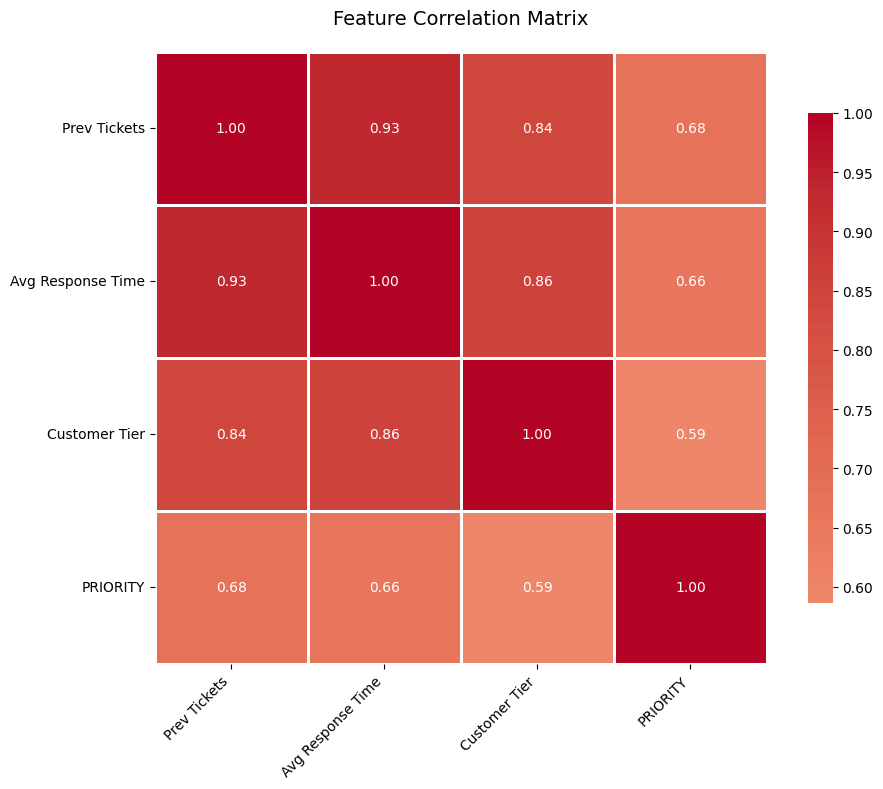


Top correlations with PRIORITY (target):
  Prev Tickets: 0.675
  Avg Response Time: 0.663
  Customer Tier: 0.587


In [ ]:
print("CORRELATION HEATMAP")

# Select numerical features
numerical_features = ["num_prev_tickets", "avg_response_time_prev"]

# Encode categorical features for correlation analysis
df_corr = df.copy()

# Encode customer_tier (1:Classic, 2:Silver, 3:Gold, 4:Platinum)
tier_mapping = {'Classic': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}
df_corr['customer_tier_encoded'] = df_corr['customer_tier'].map(tier_mapping)

# Encode priority (target) as numeric
priority_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df_corr['priority_encoded'] = df_corr['priority'].map(priority_mapping)

# Select ALL features for correlation (numerical + encoded)
corr_features = numerical_features + ['customer_tier_encoded', 'priority_encoded']
feature_names = ['Prev Tickets', 'Avg Response Time', 'Customer Tier', 'PRIORITY']

print("\nFeatures in correlation matrix:")
for i, feature in enumerate(corr_features):
    print(f"  {feature_names[i]}: {feature}")

# Calculate correlation matrix
corr_matrix = df_corr[corr_features].corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
                      center=0, square=True, linewidths=1,
                      cbar_kws={"shrink": 0.8},
                      xticklabels=feature_names,
                      yticklabels=feature_names,
                      annot_kws={"size": 10})

plt.title("Feature Correlation Matrix",
          fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print key correlations with PRIORITY
print("\nTop correlations with PRIORITY (target):")
priority_corrs = corr_matrix['priority_encoded'].sort_values(ascending=False)
for feature, corr in priority_corrs.items():
    if feature != 'priority_encoded':
        feature_name = feature_names[corr_features.index(feature)]
        print(f"  {feature_name}: {corr:.3f}")

CATEGORICAL FEATURES ANALYSIS

Analyzing: customer_tier


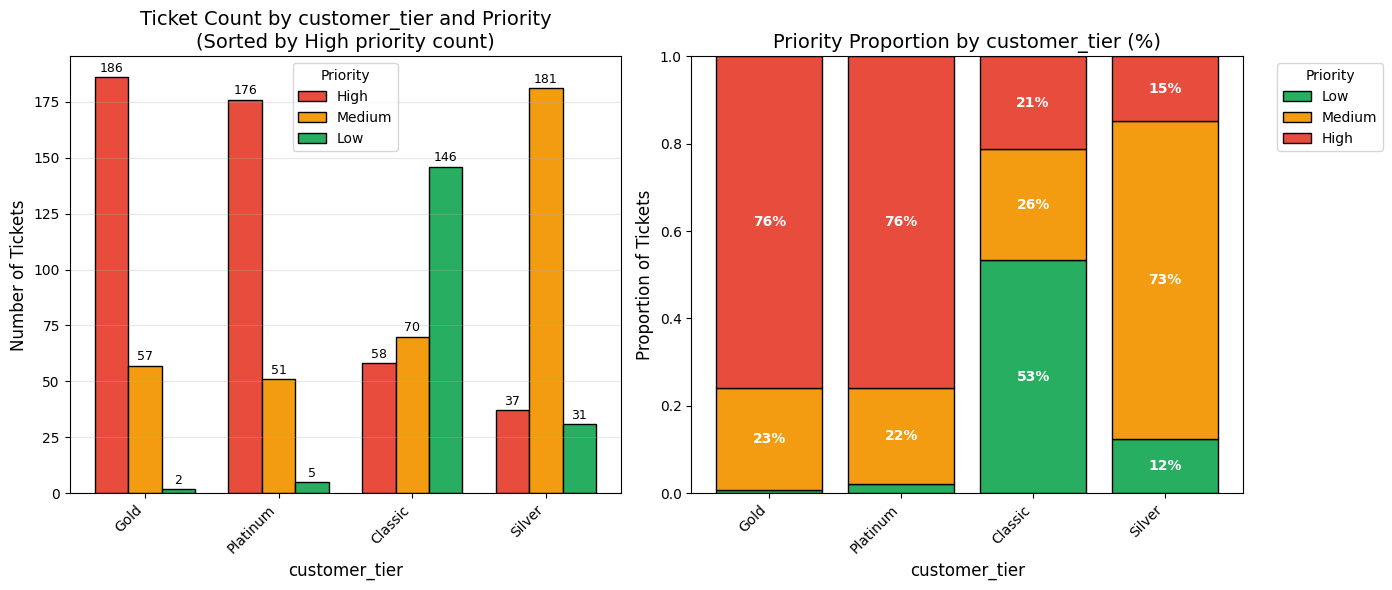

  Categories: 4
  Highest High priority: Gold (75.9%)
  Lowest High priority: Silver (14.9%)

Analyzing: issue_type


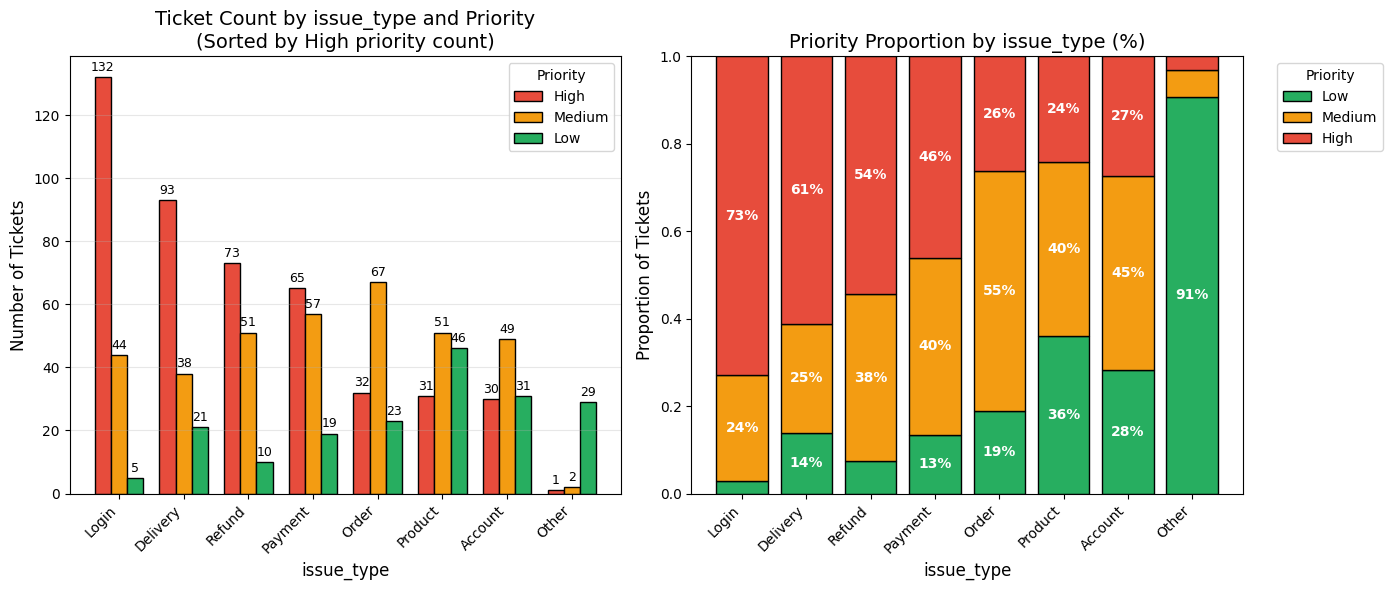

  Categories: 8
  Highest High priority: Login (72.9%)
  Lowest High priority: Other (3.1%)


In [ ]:
print("CATEGORICAL FEATURES ANALYSIS")

categorical_features = ["customer_tier", "issue_type"]

for feature in categorical_features:
    print(f"\nAnalyzing: {feature}")

    # Use complete cases for clean visualization
    temp_df = df[[feature, 'priority']].copy()

    if len(temp_df) > 0:
        # Create cross-tabulation
        cross_tab = pd.crosstab(temp_df[feature], temp_df['priority'])

        # Sort by 'High' priority count (descending)
        cross_tab['High'] = cross_tab.get('High', 0)
        cross_tab = cross_tab.sort_values('High', ascending=False)

        # Calculate proportions for each priority within category
        cross_tab_prop = cross_tab.div(cross_tab.sum(axis=1), axis=0)

        # Visualization 1: Grouped Bar Chart (Counts)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Grouped bars for counts
        x = np.arange(len(cross_tab))
        width = 0.25

        # Define consistent colors
        priority_colors = {'High': '#e74c3c', 'Medium': '#f39c12', 'Low': '#27ae60'}

        for i, priority in enumerate(['High', 'Medium', 'Low']):
            if priority in cross_tab.columns:
                offset = (i - 1) * width
                bars = ax1.bar(x + offset, cross_tab[priority], width,
                              label=priority, color=priority_colors[priority],
                              edgecolor='black')

                # Add count labels on bars
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                                f'{int(height)}', ha='center', va='bottom', fontsize=9)

        ax1.set_xlabel(feature, fontsize=12)
        ax1.set_ylabel('Number of Tickets', fontsize=12)
        ax1.set_title(f'Ticket Count by {feature} and Priority\n(Sorted by High priority count)', fontsize=14)
        ax1.set_xticks(x)
        ax1.set_xticklabels(cross_tab.index, rotation=45, ha='right')
        ax1.legend(title='Priority')
        ax1.grid(axis='y', alpha=0.3)

        # Visualization 2: Stacked Percentage Bar Chart
        bottom = np.zeros(len(cross_tab_prop))

        for priority in ['Low', 'Medium', 'High']:  # Reverse order for stacking
            if priority in cross_tab_prop.columns:
                ax2.bar(cross_tab_prop.index, cross_tab_prop[priority],
                       bottom=bottom, label=priority,
                       color=priority_colors[priority], edgecolor='black')
                bottom += cross_tab_prop[priority].values

        ax2.set_xlabel(feature, fontsize=12)
        ax2.set_ylabel('Proportion of Tickets', fontsize=12)
        ax2.set_title(f'Priority Proportion by {feature} (%)', fontsize=14)
        ax2.set_xticks(range(len(cross_tab_prop)))
        ax2.set_xticklabels(cross_tab_prop.index, rotation=45, ha='right')
        ax2.legend(title='Priority', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.set_ylim(0, 1)

        # Add percentage labels
        for i, (idx, row) in enumerate(cross_tab_prop.iterrows()):
            bottom = 0
            for priority in ['Low', 'Medium', 'High']:
                if priority in row:
                    value = row[priority]
                    if value > 0.1:  # Only label significant segments
                        ax2.text(i, bottom + value/2, f'{value:.0%}',
                                ha='center', va='center', color='white', fontweight='bold')
                    bottom += value

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print(f"  Categories: {len(cross_tab)}")
        print(f"  Highest High priority: {cross_tab.index[0]} ({cross_tab_prop.loc[cross_tab.index[0], 'High']:.1%})")
        print(f"  Lowest High priority: {cross_tab.index[-1]} ({cross_tab_prop.loc[cross_tab.index[-1], 'High']:.1%})")

TICKET TEXT ANALYSIS
Missing ticket_text values: 0 (0.0%)


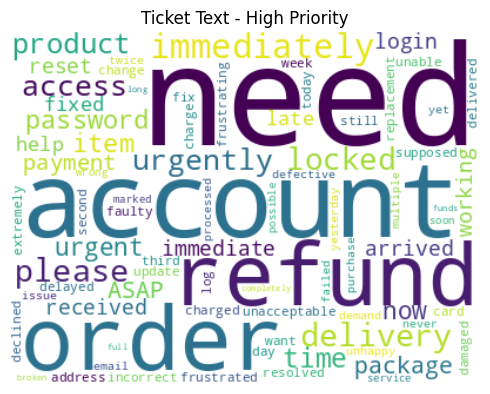

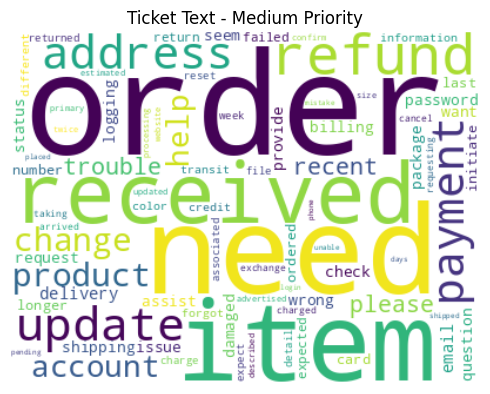

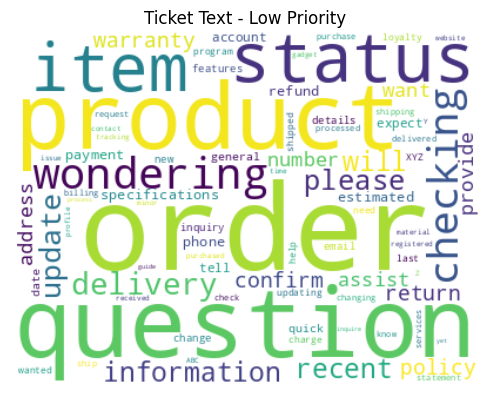

In [ ]:
print("TICKET TEXT ANALYSIS")

# Check for missing ticket_text
missing_text = df['ticket_text'].isna().sum()
print(f"Missing ticket_text values: {missing_text} ({missing_text/len(df)*100:.1f}%)")

# Prepare text data (handle missing)
df_text = df[['ticket_text', 'priority']].dropna(subset=['ticket_text'])

if len(df_text) > 0:
    # Split text by priority
    for priority_level in ['High', 'Medium', 'Low']:
        priority_text = " ".join(df_text[df_text['priority'] == priority_level]['ticket_text'].astype(str))

        if len(priority_text.strip()) > 0:
            # Generate word cloud
            wc = WordCloud(width=400, height=300,
                          max_words=80,
                          background_color="white",
                          collocations=False).generate(priority_text)

            plt.figure(figsize=(5, 4))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Ticket Text - {priority_level} Priority", fontsize=12)
            plt.tight_layout()
            plt.show()

# Feature Engineering 1 (Syarifah)

In [ ]:
!pip install torch torchvision torchaudio transformers accelerate bitsandbytes --quiet
from transformers import pipeline
import pandas as pd
import torch

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # 0 = GPU, -1 = CPU
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

# Load DistilBERT sentiment analysis model
print("Loading DistilBERT sentiment analysis model...")
sentiment_pipeline = pipeline("sentiment-analysis",
                             model="distilbert-base-uncased-finetuned-sst-2-english")

Using device: GPU
Loading DistilBERT sentiment analysis model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# FE Task 1 - Sentiment Score

def compute_sentiment_distilbert(text):
    """
    Compute sentiment polarity score using DistilBERT.
    Returns value: -1.0 (negative) to 1.0 (positive), weighted by confidence.
    """
    if pd.isna(text) or str(text).strip() == "":
        return 0.0

    # Truncate to 512 tokens (DistilBERT's limit)
    truncated_text = str(text)[:512]

    try:
        result = sentiment_pipeline(truncated_text)[0]
        # Convert to numeric score: POSITIVE -> +1, NEGATIVE -> -1
        base_score = 1.0 if result['label'] == 'POSITIVE' else -1.0
        # Weight by confidence score
        weighted_score = base_score * result['score']
        return weighted_score
    except Exception as e:
        print(f"Error processing text: {e}")
        return 0.0

# Apply sentiment analysis to ticket_text
print("Computing sentiment scores...")
df["sentiment_score"] = df["ticket_text"].apply(compute_sentiment_distilbert)

# Display results
print("\nSentiment Score Distribution:")
print(df["sentiment_score"].describe())
print(f"\nSample results:")
for idx, row in df.head(3).iterrows():
    print(f"Ticket ID: {row['ticket_id']}")
    print(f"Text snippet: {str(row['ticket_text'])[:100]}...")
    print(f"Sentiment Score: {row['sentiment_score']:.3f}")
    print("-" * 50)

Computing sentiment scores...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Sentiment Score Distribution:
count    1000.000000
mean       -0.882963
std         0.434640
min        -0.999818
25%        -0.999571
50%        -0.998851
75%        -0.994896
max         0.999659
Name: sentiment_score, dtype: float64

Sample results:
Ticket ID: T000001
Text snippet: I cannot login to my account, it says my password is wrong....
Sentiment Score: -0.999
--------------------------------------------------
Ticket ID: T000002
Text snippet: My credit card was charged twice for the same order....
Sentiment Score: -0.994
--------------------------------------------------
Ticket ID: T000003
Text snippet: My package has not arrived yet, it was supposed to be here two days ago....
Sentiment Score: -0.998
--------------------------------------------------


In [ ]:
# FE Task 1 - Urgent Keyword Flag
from transformers import pipeline
import pandas as pd
import re

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1  # 0 = GPU, -1 = CPU
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

# Load TWO pipelines for different tasks
print("Loading DistilBERT models...")
sentiment_pipeline = pipeline("sentiment-analysis",
                             model="distilbert-base-uncased-finetuned-sst-2-english")

# Load a model that can detect urgency/importance
zero_shot_pipeline = pipeline("zero-shot-classification",
                             model="typeform/distilbert-base-uncased-mnli")

def detect_urgency_hybrid(text):
    """
    Hybrid: DistilBERT does classification + sentiment
    """
    if pd.isna(text) or str(text).strip() == "":
        return 0

    text_str = str(text)
    text_lower = text_str.lower()

    urgency_signals = 0

    # DISTILBERT SIGNAL 1: Zero-Shot Urgency Detection
    try:
        truncated_text = text_str[:512]

        # Ask DistilBERT directly: "Is this urgent?"
        zero_shot_result = zero_shot_pipeline(
            truncated_text,
            candidate_labels=["urgent ticket", "non-urgent ticket", "routine request"]
        )

        # If "urgent ticket" is top prediction with high confidence
        if (zero_shot_result['labels'][0] == "urgent ticket" and
            zero_shot_result['scores'][0] > 0.7):
            urgency_signals += 2  # Strong signal from DistilBERT
            #print(f"  DistilBERT classified as URGENT (confidence: {zero_shot_result['scores'][0]:.2f})")

    except Exception as e:
        print(f"Zero-shot error: {e}")

    # DISTILBERT SIGNAL 2: Negative Sentiment
    try:
        sentiment_result = sentiment_pipeline(truncated_text)[0]

        # Strong negative sentiment often indicates urgency
        if sentiment_result['label'] == 'NEGATIVE' and sentiment_result['score'] > 0.8:
            urgency_signals += 1
            #print(f"  Negative sentiment (confidence: {sentiment_result['score']:.2f})")

    except Exception as e:
        pass

    # RULE-BASED SIGNALS (Supplementary)
    # Only use rules as tie-breakers or additional signals

    # 1. Time-critical words (supplementary)
    time_words = ["asap", "emergency", "critical"]
    if any(word in text_lower for word in time_words):
        urgency_signals += 0.5  # Weaker signal

    # 2. Exclamation marks (emotional intensity)
    if text_str.count('!') >= 1:
        urgency_signals += 0.5

    # 3. ALL CAPS shouting
    all_caps = re.findall(r'\b[A-Z]{4,}\b', text_str)
    if len(all_caps) >= 1:
        urgency_signals += 0.5

    # DECISION LOGIC
    # DistilBERT signals are weighted more heavily
    if urgency_signals >= 1.5:  # Lower threshold since DistilBERT is primary
        return 1  # Urgent
    else:
        return 0  # Not urgent

# Apply the hybrid approach
print("\nDetecting urgency using hybrid approach...")
df["urgent_flag"] = df["ticket_text"].apply(detect_urgency_hybrid)

Using device: GPU
Loading DistilBERT models...


Device set to use cuda:0


config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0



Detecting urgency using hybrid approach...


# Feature Engineering 2 (Bushra)

In [ ]:
# FE Task 2 - Activity Level
def activity_risk_simple(row):
    """
    Simple thresholds based on percentiles of range
    Tickets: 0-15, Response: 0-48
    """
    tickets = row["num_prev_tickets"]  # 0-15
    response = row["avg_response_time_prev"]  # 0-48

    # Use ~30th and ~70th percentiles of max range
    # For tickets (0-15): 5 tickets = ~33%, 10 tickets = ~67%
    # For response (0-48): 16 hours = ~33%, 32 hours = ~67%

    if tickets >= 10 or response >= 32:  # Top ~33% of range
        return "High"
    elif tickets >= 5 or response >= 16:  # Middle ~33% of range
        return "Medium"
    else:
        return "Low"

df["activity_level"] = df.apply(activity_risk_simple, axis=1)

In [ ]:
df.head()

,ticket_id,ticket_date,customer_id,customer_tier,num_prev_tickets,avg_response_time_prev,issue_type,ticket_text,priority,sentiment_score,urgent_flag,activity_level
0,T000001,21/10/2025 16:14,C12345,Classic,2.0,15.5,Login,"I cannot login to my account, it says my passw...",High,-0.998793,0,Low
1,T000002,22/10/2025 1:49,C67890,Silver,4.0,22.1,Payment,My credit card was charged twice for the same ...,Medium,-0.994278,0,Medium
2,T000003,22/10/2025 9:58,C11223,Gold,7.0,30.2,Delivery,"My package has not arrived yet, it was suppose...",High,-0.997925,0,Medium
3,T000004,22/10/2025 18:42,C44556,Platinum,9.0,45.0,Refund,I need a refund for a product that arrived bro...,High,-0.999804,0,High
4,T000005,23/10/2025 2:19,C77889,Classic,1.0,8.0,Product,I have a question about the product specificat...,Low,-0.999468,0,Low


In [ ]:
OUTPUT_FILENAME = "final_tickets.csv"
df.to_csv(OUTPUT_FILENAME, index=False)

# Feature Encoding and Selection

In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv('final_tickets.csv')

In [ ]:
# Target variable
y = df["priority"]

# Encode categorical features
# 1. customer_tier (ordinal - higher tiers are more valuable)
tier_map = {"Classic": 0, "Silver": 1, "Gold": 2, "Platinum": 3}
df["customer_tier_enc"] = df["customer_tier"].map(tier_map)

# 2. issue_type (nominal - use label encoding
issue_types = df["issue_type"].unique()
issue_map = {issue: i for i, issue in enumerate(sorted(issue_types))}
df["issue_type_enc"] = df["issue_type"].map(issue_map)

# 3. activity_level (ordinal - based on feature engineering)
activity_map = {"Low": 0, "Medium": 1, "High": 2}
df["activity_level_enc"] = df["activity_level"].map(activity_map)

# Select features for modeling
feature_cols = [
    # Engineered features from text analysis
    "sentiment_score",        # numeric from DistilBERT (-1 to 1)
    "urgent_flag",           # binary from hybrid detection (0/1)

    # Original categorical features (encoded)
    "customer_tier_enc",     # encoded customer tier
    "issue_type_enc",        # encoded issue type

    # Feature engineered from customer behavior
    "activity_level_enc",    # encoded activity level
]

X = df[feature_cols]

# Check shapes and distributions
print("FEATURE MATRIX (X) SHAPE:", X.shape)
print("\nFirst 5 rows of feature matrix:")
print(X.head())
print("\nFeature data types:")
print(X.dtypes)

print("\nTARGET VARIABLE (y) DISTRIBUTION:")
print(y.value_counts())
print(f"\nTarget classes: {y.unique()}")
print(f"Target dtype: {y.dtype}")

# Show encoding mappings for reference
print("\nENCODING MAPPINGS:")
print("customer_tier mapping:", tier_map)
print("issue_type mapping:", issue_map)
print("activity_level mapping:", activity_map)

FEATURE MATRIX (X) SHAPE: (1000, 5)

First 5 rows of feature matrix:
   sentiment_score  urgent_flag  customer_tier_enc  issue_type_enc  \
0        -0.998793            0                  0               2   
1        -0.994278            0                  1               5   
2        -0.997925            0                  2               1   
3        -0.999804            0                  3               7   
4        -0.999468            0                  0               6   

   activity_level_enc  
0                   0  
1                   1  
2                   1  
3                   2  
4                   0  

Feature data types:
sentiment_score       float64
urgent_flag             int64
customer_tier_enc       int64
issue_type_enc          int64
activity_level_enc      int64
dtype: object

TARGET VARIABLE (y) DISTRIBUTION:
priority
High      457
Medium    359
Low       184
Name: count, dtype: int64

Target classes: ['High' 'Medium' 'Low']
Target dtype: object

ENCODI

# Decision Tree (Sanjida)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Encode target labels for ROC-AUC
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Decision Tree classifier
dt_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

In [ ]:
# Fit model
dt_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred = dt_model.predict(X_test)
y_proba = dt_model.predict_proba(X_test)

In [ ]:
# Evaluation metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test_encoded, y_proba, multi_class='ovr', average='weighted')

dt_metrics = {
    "Model": "Decision Tree",
    "Accuracy": round(accuracy, 4),
    "F1 Score": round(f1, 4),
    "ROC-AUC": round(roc_auc, 4)
}

print("Decision Tree Metrics:", dt_metrics)
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred,
                                                         target_names=le.classes_))

Decision Tree Metrics: {'Model': 'Decision Tree', 'Accuracy': 0.735, 'F1 Score': 0.7362, 'ROC-AUC': np.float64(0.7952)}

Classification Report:
               precision    recall  f1-score   support

        High       0.84      0.81      0.83        91
         Low       0.63      0.65      0.64        37
      Medium       0.66      0.68      0.67        72

    accuracy                           0.73       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.74      0.73      0.74       200




Decision Tree Feature Importances:
               Feature  Importance
0     sentiment_score    0.388620
2   customer_tier_enc    0.345884
3      issue_type_enc    0.173897
4  activity_level_enc    0.055801
1         urgent_flag    0.035797


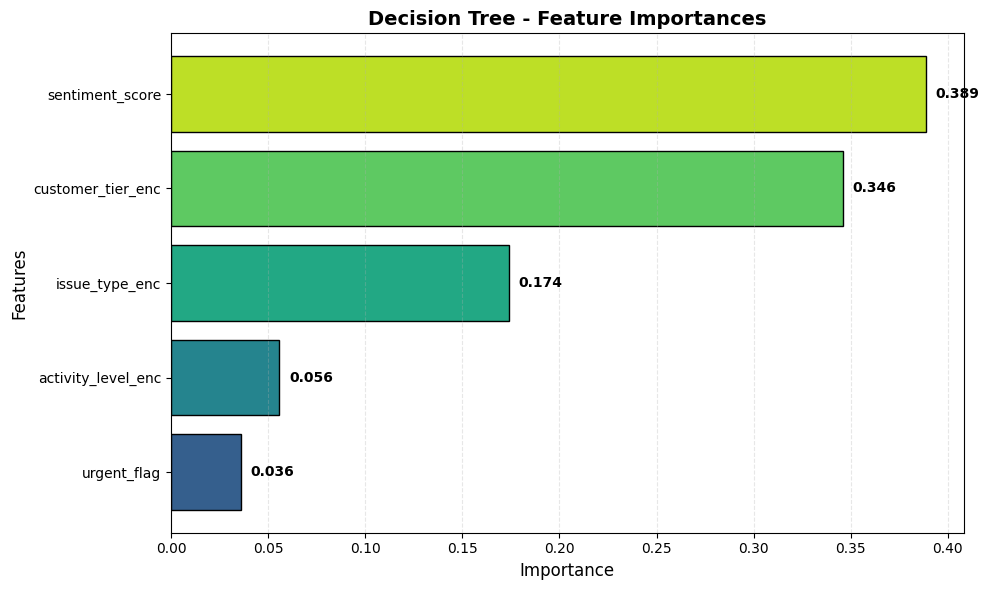

In [ ]:
# Feature Importances DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": dt_model.feature_importances_
}).sort_values(by="Importance", ascending=True)  # Sort for horizontal bar chart

print("\nDecision Tree Feature Importances:\n", importances_df.sort_values(by="Importance", ascending=False))

# Visualize Feature Importance as Horizontal Bar Chart
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importances_df)))
bars = plt.barh(importances_df['Feature'], importances_df['Importance'], color=colors, edgecolor='black')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Decision Tree - Feature Importances', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Store results for model comparison
dt_results = {
    'model_name': 'Decision Tree',
    'metrics': dt_metrics,
    'feature_importances': importances_df
}

# Logistic Regression (Syarifah)

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Encode target labels for ROC-AUC
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Fit Logistic Regression
log_reg = LogisticRegression(
    max_iter=1000,
    random_state=42
)

log_reg.fit(X_train_scaled, y_train_encoded)

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)

In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test_encoded, y_proba, multi_class='ovr', average='weighted')

lr_metrics = {
    "Model": "Logistic Regression",
    "Accuracy": round(accuracy, 4),
    "F1 Score": round(f1, 4),
    "ROC-AUC": round(roc_auc, 4)
}

print("Logistic Regression Metrics:", lr_metrics)
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred,
                                                         target_names=le.classes_))

Logistic Regression Metrics: {'Model': 'Logistic Regression', 'Accuracy': 0.68, 'F1 Score': 0.6818, 'ROC-AUC': np.float64(0.8596)}

Classification Report:
               precision    recall  f1-score   support

        High       0.81      0.76      0.78        91
         Low       0.54      0.73      0.62        37
      Medium       0.62      0.56      0.58        72

    accuracy                           0.68       200
   macro avg       0.66      0.68      0.66       200
weighted avg       0.69      0.68      0.68       200




Logistic Regression Feature Importances (absolute coefficients):
               Feature  Importance
1         urgent_flag    0.933917
4  activity_level_enc    0.814878
2   customer_tier_enc    0.579970
0     sentiment_score    0.122487
3      issue_type_enc    0.091091


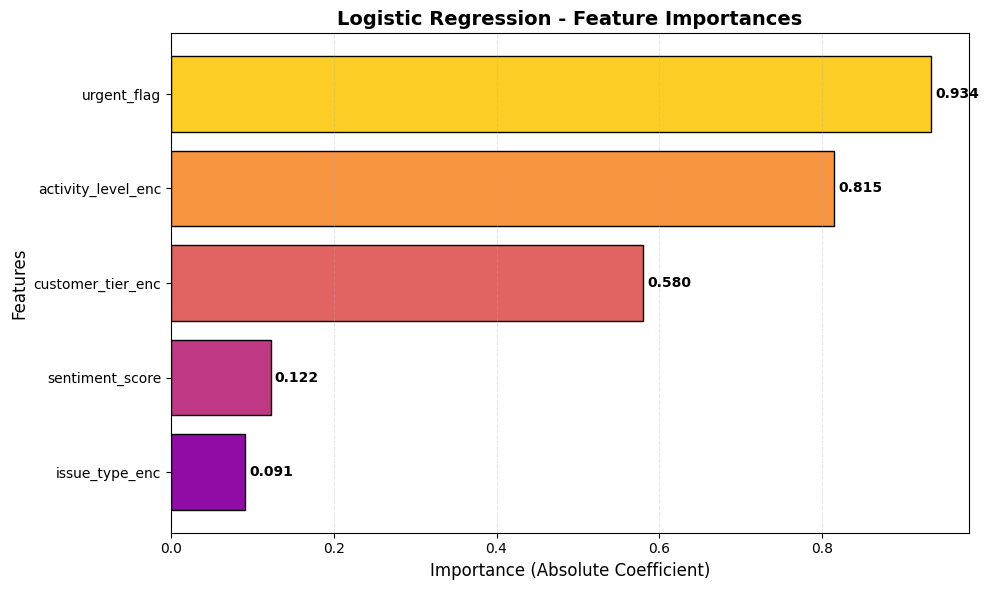

In [ ]:
# Feature Importances (coefficients - take absolute values for importance)
coef_abs = np.abs(log_reg.coef_[0])  # Take first class coefficients or average across classes
importances_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": coef_abs
}).sort_values(by="Importance", ascending=True)  # Sort for horizontal bar chart

print("\nLogistic Regression Feature Importances (absolute coefficients):\n",
      importances_df.sort_values(by="Importance", ascending=False))

# Visualize Feature Importance as Horizontal Bar Chart
plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(importances_df)))
bars = plt.barh(importances_df['Feature'], importances_df['Importance'], color=colors, edgecolor='black')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.xlabel('Importance (Absolute Coefficient)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Logistic Regression - Feature Importances', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Store results for model comparison
lr_results = {
    'model_name': 'Logistic Regression',
    'metrics': lr_metrics,
    'feature_importances': importances_df
}

# Random Forest (Bushra)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Encode target labels for ROC-AUC
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)

In [ ]:
rf.fit(X_train, y_train_encoded)

# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)  # Get all class probabilities

In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test_encoded, y_proba, multi_class='ovr', average='weighted')

rf_metrics = {
    "Model": "Random Forest",
    "Accuracy": round(accuracy, 4),
    "F1 Score": round(f1, 4),
    "ROC-AUC": round(roc_auc, 4)
}

print("Random Forest Metrics:", rf_metrics)
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred,
                                                         target_names=le.classes_))

Random Forest Metrics: {'Model': 'Random Forest', 'Accuracy': 0.75, 'F1 Score': 0.7498, 'ROC-AUC': np.float64(0.9051)}

Classification Report:
               precision    recall  f1-score   support

        High       0.84      0.84      0.84        91
         Low       0.72      0.62      0.67        37
      Medium       0.66      0.71      0.68        72

    accuracy                           0.75       200
   macro avg       0.74      0.72      0.73       200
weighted avg       0.75      0.75      0.75       200




Random Forest Feature Importances:
               Feature  Importance
0     sentiment_score    0.427775
2   customer_tier_enc    0.222525
3      issue_type_enc    0.167772
4  activity_level_enc    0.135470
1         urgent_flag    0.046457


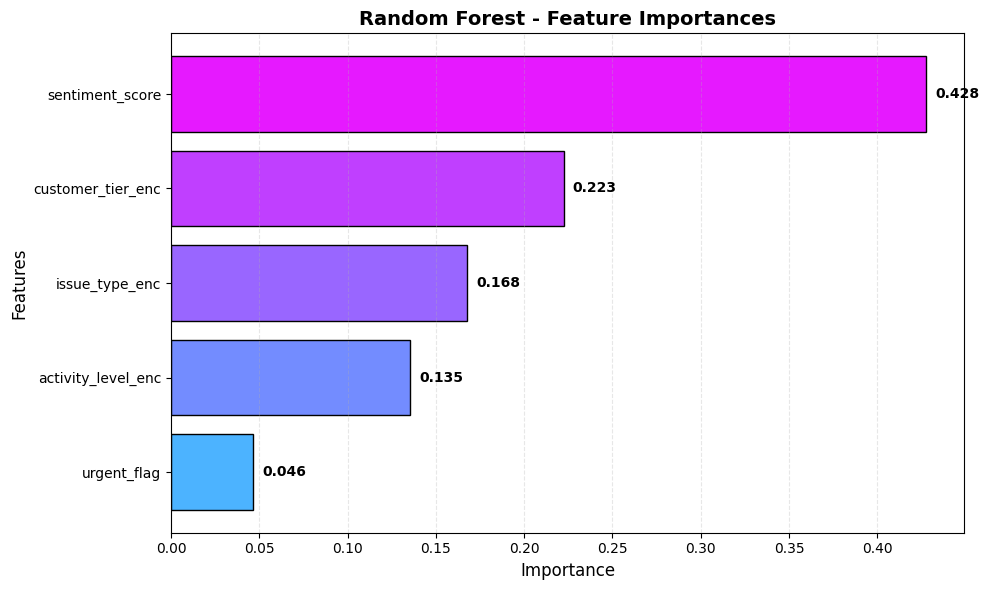

In [ ]:
# Feature Importances DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=True)  # Sort for horizontal bar chart

print("\nRandom Forest Feature Importances:\n", importances_df.sort_values(by="Importance", ascending=False))

# Visualize Feature Importance as Horizontal Bar Chart
plt.figure(figsize=(10, 6))
colors = plt.cm.cool(np.linspace(0.3, 0.9, len(importances_df)))
bars = plt.barh(importances_df['Feature'], importances_df['Importance'], color=colors, edgecolor='black')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Random Forest - Feature Importances', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Store results for model comparison
rf_results = {
    'model_name': 'Random Forest',
    'metrics': rf_metrics,
    'feature_importances': importances_df
}

# XGBoost (Adhia)

In [ ]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Encode target labels for XGBoost and ROC-AUC
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'  # For multiclass classification
)

In [ ]:
# Fit model
xgb_model.fit(X_train, y_train_encoded)

# Predictions
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)  # Get all class probabilities

In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test_encoded, y_proba, multi_class='ovr', average='weighted')

xgb_metrics = {
    "Model": "XGBoost",
    "Accuracy": round(accuracy, 4),
    "F1 Score": round(f1, 4),
    "ROC-AUC": round(roc_auc, 4)
}

print("XGBoost Metrics:", xgb_metrics)
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred,
                                                         target_names=le.classes_))

XGBoost Metrics: {'Model': 'XGBoost', 'Accuracy': 0.795, 'F1 Score': 0.7929, 'ROC-AUC': np.float64(0.9131)}

Classification Report:
               precision    recall  f1-score   support

        High       0.89      0.91      0.90        91
         Low       0.71      0.59      0.65        37
      Medium       0.71      0.75      0.73        72

    accuracy                           0.80       200
   macro avg       0.77      0.75      0.76       200
weighted avg       0.79      0.80      0.79       200




XGBoost Feature Importances:
               Feature  Importance
1         urgent_flag    0.353440
2   customer_tier_enc    0.284049
4  activity_level_enc    0.162578
3      issue_type_enc    0.112331
0     sentiment_score    0.087602


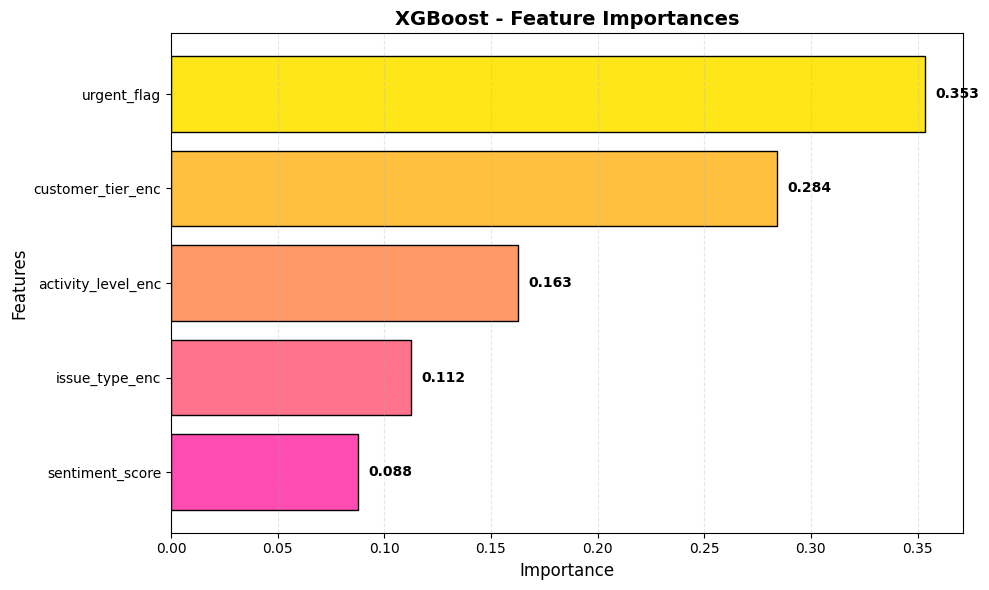

In [ ]:
# Feature Importances DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=True)  # Sort for horizontal bar chart

print("\nXGBoost Feature Importances:\n", importances_df.sort_values(by="Importance", ascending=False))

# Visualize Feature Importance as Horizontal Bar Chart
plt.figure(figsize=(10, 6))
colors = plt.cm.spring(np.linspace(0.3, 0.9, len(importances_df)))
bars = plt.barh(importances_df['Feature'], importances_df['Importance'], color=colors, edgecolor='black')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('XGBoost - Feature Importances', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Store results for model comparison
xgb_results = {
    'model_name': 'XGBoost',
    'metrics': xgb_metrics,
    'feature_importances': importances_df
}

# k-NN (Hani)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Encode target labels for ROC-AUC
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Create preprocessing: scale only numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    metric="euclidean",
    algorithm="auto",
    weights="distance",
    n_jobs=-1
)


Training set size: 800
Test set size: 200


In [ ]:
# Fit model
print("\nFitting KNN model...")
knn_model.fit(X_train_scaled, y_train_encoded)

# Predictions
y_pred = knn_model.predict(X_test_scaled)
y_proba = knn_model.predict_proba(X_test_scaled)


Fitting KNN model...


In [ ]:
# Evaluation Metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test_encoded, y_proba, multi_class='ovr', average='weighted')

knn_metrics = {
    "Model": "K-Nearest Neighbors",
    "Accuracy": round(accuracy, 4),
    "F1 Score": round(f1, 4),
    "ROC-AUC": round(roc_auc, 4)
}

print("\nKNN Metrics:", knn_metrics)
print("\nClassification Report:\n", classification_report(y_test_encoded, y_pred,
                                                         target_names=le.classes_))


KNN Metrics: {'Model': 'K-Nearest Neighbors', 'Accuracy': 0.72, 'F1 Score': 0.7199, 'ROC-AUC': np.float64(0.8725)}

Classification Report:
               precision    recall  f1-score   support

        High       0.79      0.79      0.79        91
         Low       0.73      0.59      0.66        37
      Medium       0.63      0.69      0.66        72

    accuracy                           0.72       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.72      0.72      0.72       200




KNN Feature Importances (Permutation):
               Feature  Importance
4  activity_level_enc    0.209324
2   customer_tier_enc    0.103106
3      issue_type_enc    0.096713
1         urgent_flag    0.060637
0     sentiment_score    0.059981


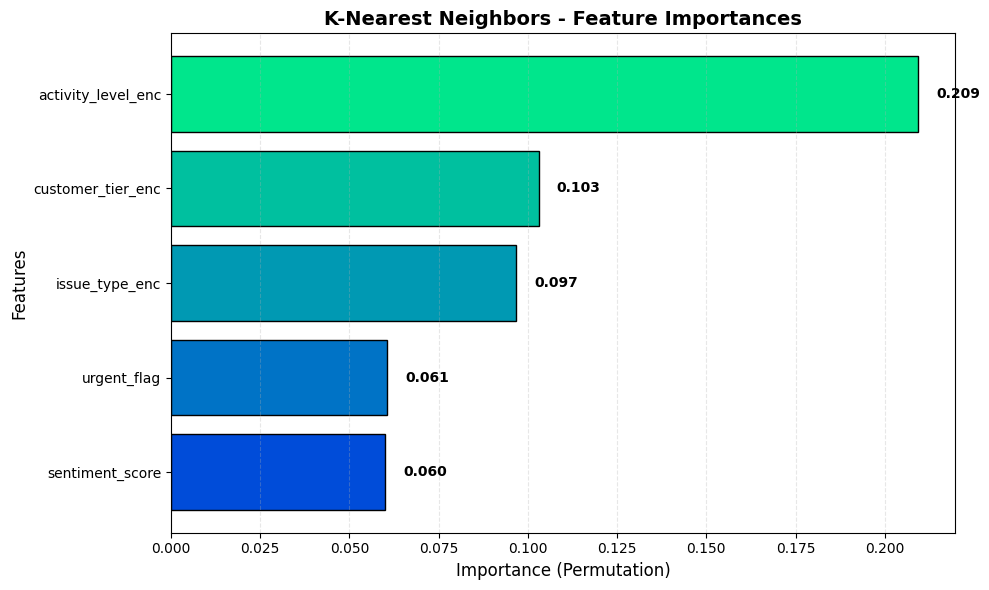

In [ ]:
perm_importance = permutation_importance(
    knn_model,
    X_test_scaled,
    y_test_encoded,
    n_repeats=10,
    random_state=42,
    scoring='f1_weighted',
    n_jobs=-1
)

# Create feature importances DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=True)  # For horizontal bar chart

print("\nKNN Feature Importances (Permutation):\n", importances_df.sort_values(by="Importance", ascending=False))

# Visualize Feature Importance as Horizontal Bar Chart
plt.figure(figsize=(10, 6))
colors = plt.cm.winter(np.linspace(0.3, 0.9, len(importances_df)))
bars = plt.barh(importances_df['Feature'], importances_df['Importance'], color=colors, edgecolor='black')

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center', fontweight='bold')

plt.xlabel('Importance (Permutation)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('K-Nearest Neighbors - Feature Importances', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Store results for model comparison
knn_results = {
    'model_name': 'K-Nearest Neighbors',
    'metrics': knn_metrics,
    'feature_importances': importances_df
}

# Saving Performance Metrics for Model Comparison

In [ ]:
# Combine all model results into a list
all_results = [dt_results, lr_results, rf_results, xgb_results, knn_results]

# Extract metrics from each result
all_metrics = []
for result in all_results:
    metrics = result['metrics'].copy()  # Make a copy to avoid modifying original
    all_metrics.append(metrics)

# Convert to DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Reorder columns for better presentation
metrics_df = metrics_df[["Model", "Accuracy", "F1 Score", "ROC-AUC"]]

# Format numbers for better readability
metrics_df["Accuracy"] = metrics_df["Accuracy"].apply(lambda x: f"{x:.4f}")
metrics_df["F1 Score"] = metrics_df["F1 Score"].apply(lambda x: f"{x:.4f}")
metrics_df["ROC-AUC"] = metrics_df["ROC-AUC"].apply(lambda x: f"{x:.4f}")

# Save to CSV
metrics_df.to_csv("model_metrics_summary.csv", index=False)

print("MODEL METRICS SUMMARY")
print(metrics_df.to_string(index=False))

feature_importance_dfs = []
for result in all_results:
    model_name = result['model_name']
    importances = result['feature_importances'].copy()
    importances['Model'] = model_name
    # Reorder columns
    importances = importances[['Model', 'Feature', 'Importance']]
    feature_importance_dfs.append(importances)

# Combine all feature importances
all_importances_df = pd.concat(feature_importance_dfs, ignore_index=True)

# Save feature importances
all_importances_df.to_csv("model_feature_importances.csv", index=False)
print(f"Saved feature importances for {len(all_results)} models to 'model_feature_importances.csv'")
print(f"Total rows: {len(all_importances_df)}")

MODEL METRICS SUMMARY
              Model Accuracy F1 Score ROC-AUC
      Decision Tree   0.7350   0.7362  0.7952
Logistic Regression   0.6800   0.6818  0.8596
      Random Forest   0.7500   0.7498  0.9051
            XGBoost   0.7950   0.7929  0.9131
K-Nearest Neighbors   0.7200   0.7199  0.8725
Saved feature importances for 5 models to 'model_feature_importances.csv'
Total rows: 25


# Model Comparison (Adhia)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load metrics from CSV
metrics_df = pd.read_csv("model_metrics_summary.csv")

In [ ]:
# Display comparison table
print("Model Comparison Table:")
print(metrics_df)

Model Comparison Table:
                 Model  Accuracy  F1 Score  ROC-AUC
0        Decision Tree     0.735    0.7362   0.7952
1  Logistic Regression     0.680    0.6818   0.8596
2        Random Forest     0.750    0.7498   0.9051
3              XGBoost     0.795    0.7929   0.9131
4  K-Nearest Neighbors     0.720    0.7199   0.8725


In [ ]:
# Sort by each metric
metrics_by_accuracy = metrics_df.sort_values(by="Accuracy", ascending=False)
metrics_by_f1 = metrics_df.sort_values(by="F1 Score", ascending=False)
metrics_by_rocauc = metrics_df.sort_values(by="ROC-AUC", ascending=False)

Accuracy Bar Chart

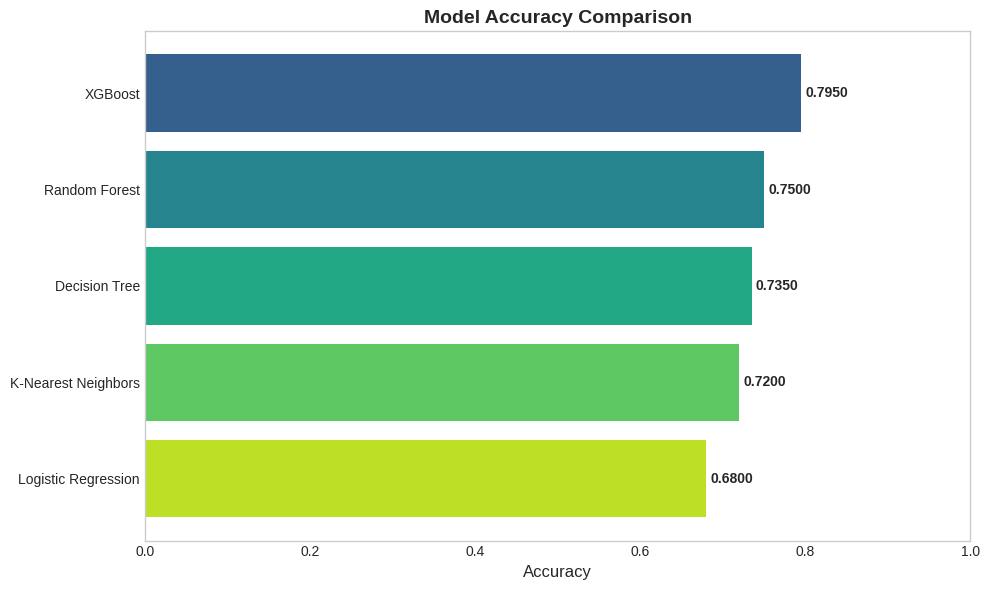

In [ ]:
# 1. SEPARATE ACCURACY BAR CHART
plt.figure(figsize=(10, 6))
bars_acc = plt.barh(metrics_by_accuracy["Model"], metrics_by_accuracy["Accuracy"],
                   color=plt.cm.viridis(np.linspace(0.3, 0.9, len(metrics_df))))
plt.xlim(0, 1.0)
plt.title("Model Accuracy Comparison", fontsize=14, fontweight='bold')
plt.xlabel("Accuracy", fontsize=12)
plt.gca().invert_yaxis()  # Highest on top

# Add value labels (outside bars)
for i, (bar, acc) in enumerate(zip(bars_acc, metrics_by_accuracy["Accuracy"])):
    plt.text(acc + 0.005, bar.get_y() + bar.get_height()/2,
            f'{acc:.4f}', ha='left', va='center', fontweight='bold')

plt.grid(False)
plt.tight_layout()
plt.show()

F1 Score Bar Chart

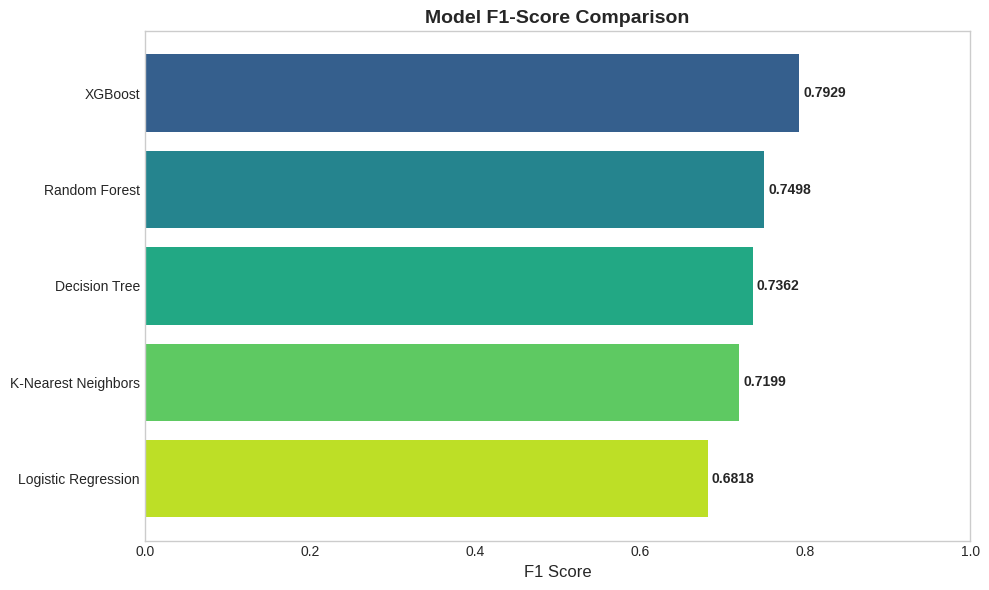

In [ ]:
# 2. SEPARATE F1 SCORE BAR CHART
plt.figure(figsize=(10, 6))
bars_f1 = plt.barh(metrics_by_f1["Model"], metrics_by_f1["F1 Score"],
                  color=plt.cm.viridis(np.linspace(0.3, 0.9, len(metrics_df))))
plt.xlim(0, 1.0)
plt.title("Model F1-Score Comparison", fontsize=14, fontweight='bold')
plt.xlabel("F1 Score", fontsize=12)
plt.gca().invert_yaxis()

for i, (bar, f1) in enumerate(zip(bars_f1, metrics_by_f1["F1 Score"])):
    plt.text(f1 + 0.005, bar.get_y() + bar.get_height()/2,
            f'{f1:.4f}', ha='left', va='center', fontweight='bold')

plt.grid(False)
plt.tight_layout()
plt.show()

ROC-AUC Bar Chart

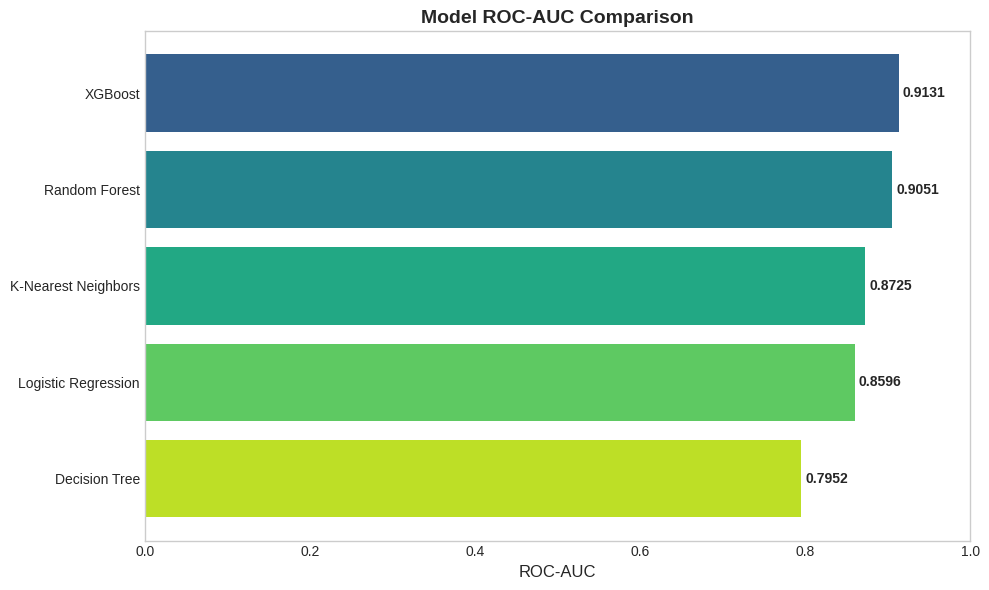

In [ ]:
# 3. SEPARATE ROC-AUC BAR CHART
plt.figure(figsize=(10, 6))
bars_auc = plt.barh(metrics_by_rocauc["Model"], metrics_by_rocauc["ROC-AUC"],
                   color=plt.cm.viridis(np.linspace(0.3, 0.9, len(metrics_df))))
plt.xlim(0, 1.0)
plt.title("Model ROC-AUC Comparison", fontsize=14, fontweight='bold')
plt.xlabel("ROC-AUC", fontsize=12)
plt.gca().invert_yaxis()

for i, (bar, auc) in enumerate(zip(bars_auc, metrics_by_rocauc["ROC-AUC"])):
    plt.text(auc + 0.005, bar.get_y() + bar.get_height()/2,
            f'{auc:.4f}', ha='left', va='center', fontweight='bold')

plt.grid(False)
plt.tight_layout()
plt.show()

Feature Importance Comparison

FEATURE IMPORTANCE VISUALIZATION
Loaded feature importances: 25 rows
Models: ['Decision Tree', 'Logistic Regression', 'Random Forest', 'XGBoost', 'K-Nearest Neighbors']
Features: ['urgent_flag', 'activity_level_enc', 'issue_type_enc', 'customer_tier_enc', 'sentiment_score']


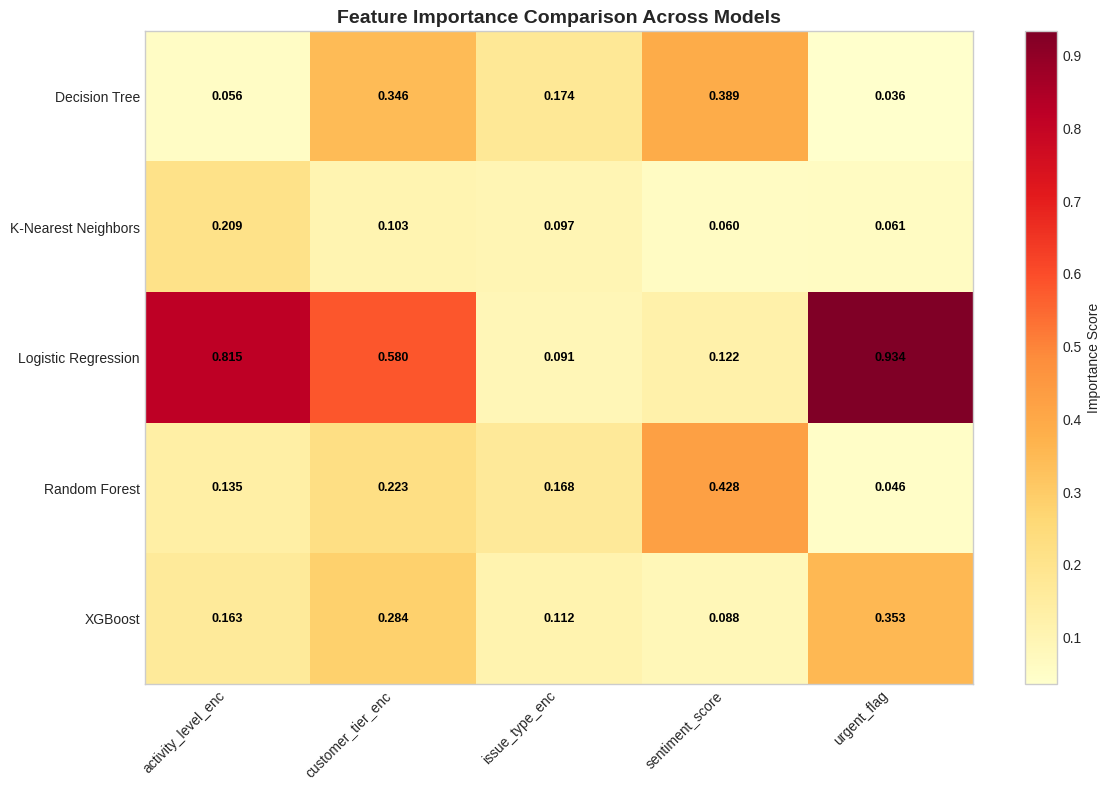

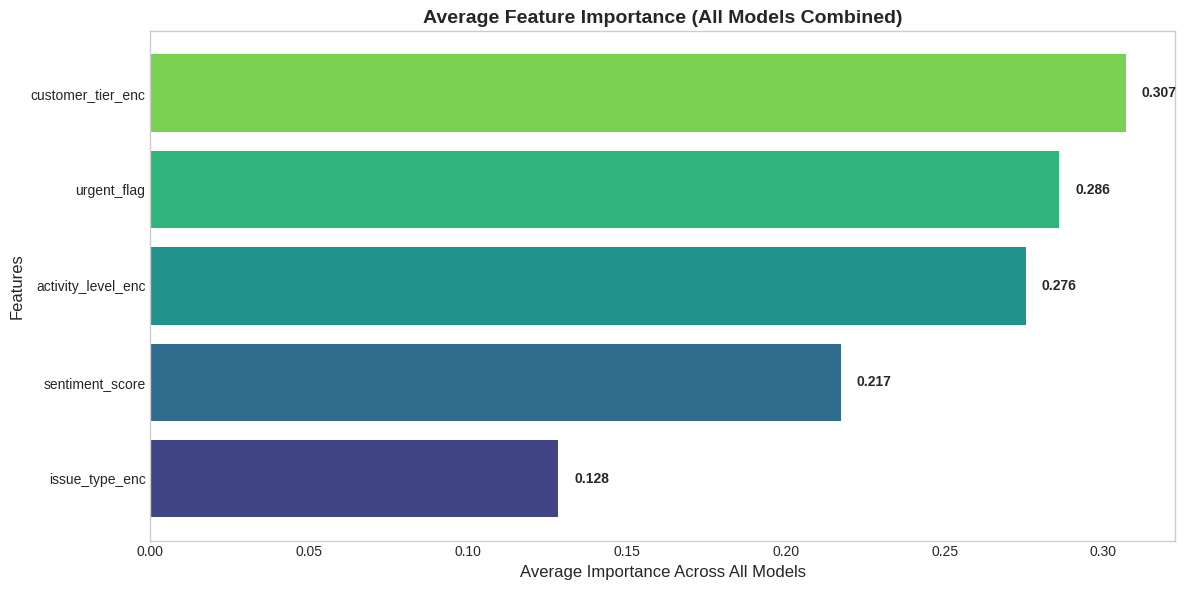

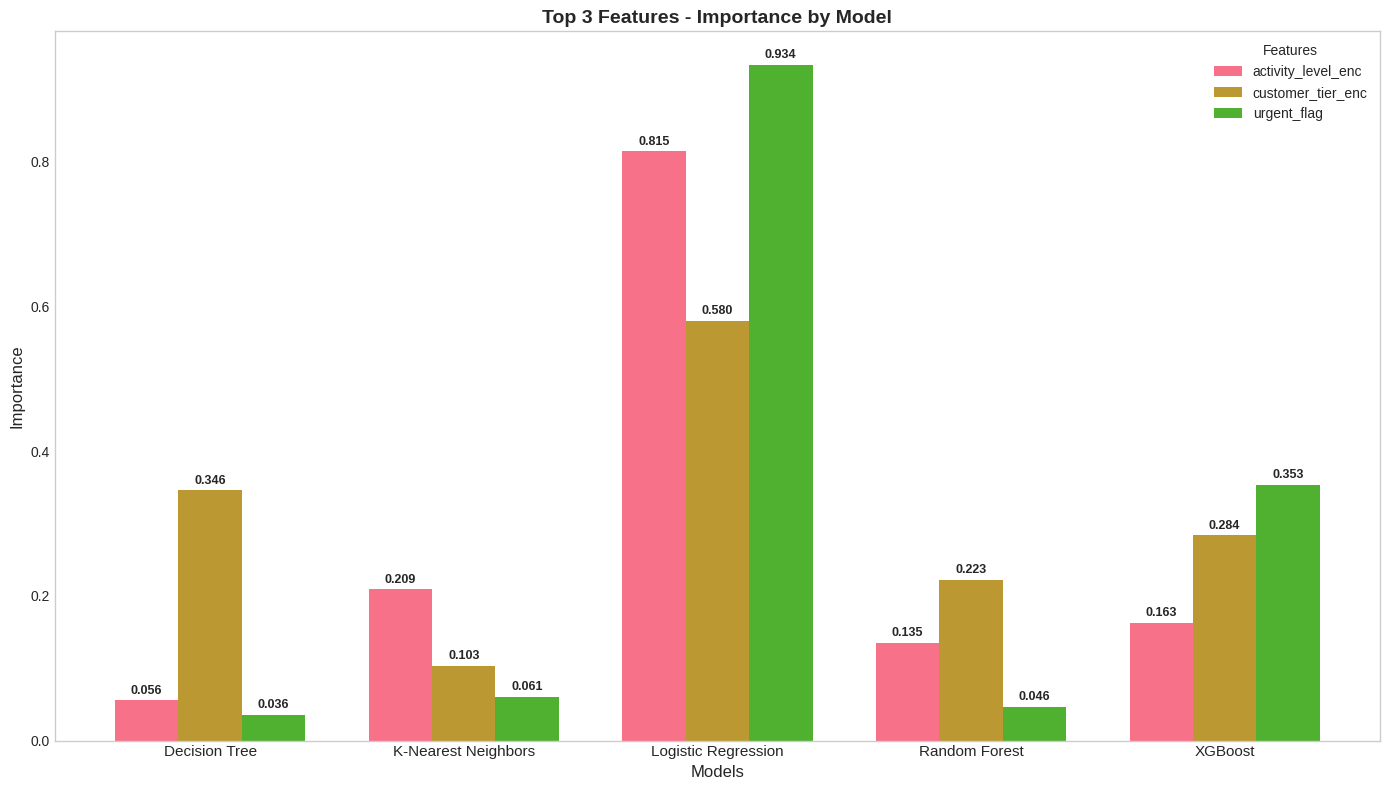

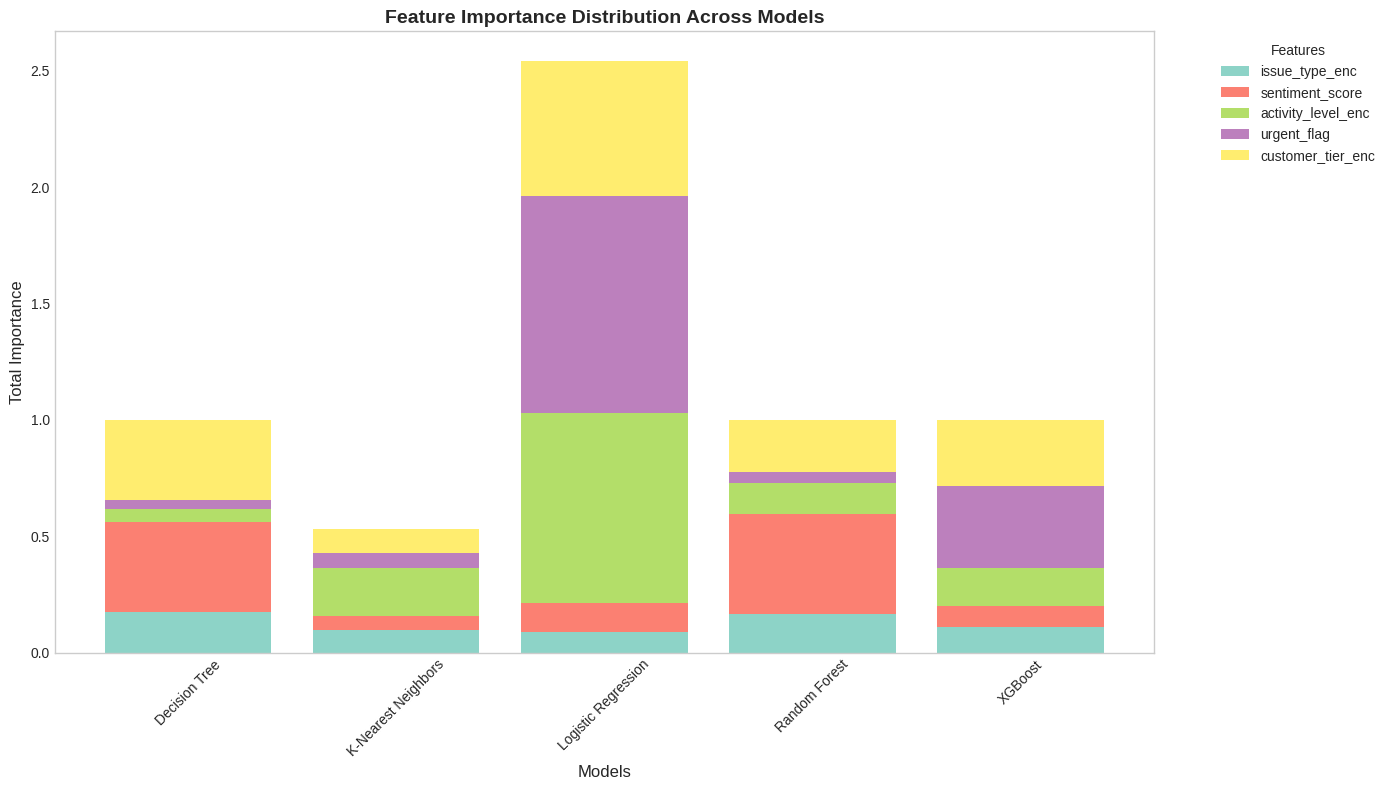

In [ ]:
# 4. FIXED Feature Importance Visualization
print("FEATURE IMPORTANCE VISUALIZATION")

# Load feature importances from the correct file
try:
    feature_importances_df = pd.read_csv("model_feature_importances.csv")
    print(f"Loaded feature importances: {len(feature_importances_df)} rows")
    print(f"Models: {feature_importances_df['Model'].unique().tolist()}")
    print(f"Features: {feature_importances_df['Feature'].unique().tolist()}")

    # Convert Importance to numeric
    feature_importances_df['Importance'] = pd.to_numeric(feature_importances_df['Importance'], errors='coerce')

    # Create pivot table for heatmap
    pivot_df = feature_importances_df.pivot(
        index='Model',
        columns='Feature',
        values='Importance'
    )

    # 5.1 Heatmap of Feature Importances
    plt.figure(figsize=(12, 8))

    # Create heatmap with numeric data
    heatmap_data = pivot_df.values
    im = plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')

    # Set labels
    plt.xticks(np.arange(len(pivot_df.columns)), pivot_df.columns, rotation=45, ha='right', fontsize=10)
    plt.yticks(np.arange(len(pivot_df.index)), pivot_df.index, fontsize=10)

    # Add text annotations
    for i in range(len(pivot_df.index)):
        for j in range(len(pivot_df.columns)):
            value = heatmap_data[i, j]
            plt.text(j, i, f'{value:.3f}', ha="center", va="center",
                    color="black", fontsize=9, fontweight='bold')

    plt.title("Feature Importance Comparison Across Models", fontsize=14, fontweight='bold')
    plt.colorbar(im, label='Importance Score')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # 5.2 Average Feature Importance (Horizontal Bar Chart)
    avg_importance = feature_importances_df.groupby('Feature')['Importance'].mean().sort_values()

    plt.figure(figsize=(12, 6))
    bars_avg = plt.barh(avg_importance.index, avg_importance.values,
                       color=plt.cm.viridis(np.linspace(0.2, 0.8, len(avg_importance))))

    plt.xlabel('Average Importance Across All Models', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('Average Feature Importance (All Models Combined)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)

    # Add value labels
    for bar in bars_avg:
        width = bar.get_width()
        plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontweight='bold')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # 5.3 Feature Importance by Model (Grouped Bar Chart)
    # Get top 3 features by average importance
    top_features = avg_importance.tail(3).index.tolist()

    # Filter data for top features
    top_data = feature_importances_df[feature_importances_df['Feature'].isin(top_features)]

    # Pivot for grouped bar chart
    grouped_data = top_data.pivot(index='Model', columns='Feature', values='Importance')

    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 8))

    x = np.arange(len(grouped_data.index))
    width = 0.25
    features = grouped_data.columns.tolist()

    for i, feature in enumerate(features):
        offset = (i - len(features)/2) * width + width/2
        ax.bar(x + offset, grouped_data[feature], width, label=feature)

    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel('Importance', fontsize=12)
    ax.set_title('Top 3 Features - Importance by Model', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(grouped_data.index, rotation=0, fontsize=11)
    ax.legend(title='Features', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, feature in enumerate(features):
        for j, model in enumerate(grouped_data.index):
            value = grouped_data.loc[model, feature]
            offset = (i - len(features)/2) * width + width/2
            ax.text(j + offset, value + 0.005, f'{value:.3f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # 5.4 Stacked Bar Chart for Feature Importance Distribution
    plt.figure(figsize=(14, 8))

    # Sort features by average importance for consistent ordering
    feature_order = avg_importance.sort_values().index.tolist()

    # Prepare data for stacked bars
    stacked_data = []
    for model in pivot_df.index:
        model_data = [pivot_df.loc[model, feature] for feature in feature_order]
        stacked_data.append(model_data)

    # Create stacked bar chart
    bottom_vals = np.zeros(len(pivot_df.index))
    colors_stacked = plt.cm.Set3(np.linspace(0, 1, len(feature_order)))

    for i, feature in enumerate(feature_order):
        values = [pivot_df.loc[model, feature] for model in pivot_df.index]
        plt.bar(pivot_df.index, values, bottom=bottom_vals,
                label=feature, color=colors_stacked[i])
        bottom_vals += values

    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Total Importance', fontsize=12)
    plt.title('Feature Importance Distribution Across Models', fontsize=14, fontweight='bold')
    plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: 'model_feature_importances.csv' file not found.")
except Exception as e:
    print(f"Error loading feature importances: {e}")
    import traceback
    traceback.print_exc()

Performance Summary

In [ ]:
# 5. Summary Statistics
print("PERFORMANCE SUMMARY STATISTICS")
print(f"Best Accuracy: {metrics_df['Accuracy'].max():.4f} ({metrics_df.loc[metrics_df['Accuracy'].idxmax(), 'Model']})")
print(f"Best F1 Score: {metrics_df['F1 Score'].max():.4f} ({metrics_df.loc[metrics_df['F1 Score'].idxmax(), 'Model']})")
print(f"Best ROC-AUC: {metrics_df['ROC-AUC'].max():.4f} ({metrics_df.loc[metrics_df['ROC-AUC'].idxmax(), 'Model']})")
print(f"\nAverage Accuracy: {metrics_df['Accuracy'].mean():.4f}")
print(f"Average F1 Score: {metrics_df['F1 Score'].mean():.4f}")
print(f"Average ROC-AUC: {metrics_df['ROC-AUC'].mean():.4f}")

PERFORMANCE SUMMARY STATISTICS
Best Accuracy: 0.7950 (XGBoost)
Best F1 Score: 0.7929 (XGBoost)
Best ROC-AUC: 0.9131 (XGBoost)

Average Accuracy: 0.7360
Average F1 Score: 0.7361
Average ROC-AUC: 0.8691


# LLM Interpretation & Insights (Hani)

In [ ]:
import pandas as pd
import time
from google import genai

# CONFIGURATION
# Use 3 different API keys
API_KEYS = {
    "key1": "KEY1",
    "key2": "KEY2",
    "key3": "KEY3"
}

MODEL_NAME = "gemini-2.5-flash-lite"

In [ ]:
# Load model metrics and feature importances
metrics_df = pd.read_csv("model_metrics_summary.csv")
feature_importances_df = pd.read_csv("model_feature_importances.csv")

# Convert string metrics to numeric for proper sorting
for col in ['Accuracy', 'F1 Score', 'ROC-AUC']:
    metrics_df[col] = pd.to_numeric(metrics_df[col], errors='coerce')

# Sort by ROC-AUC (best overall ranking for classification)
metrics_sorted = metrics_df.sort_values(by="ROC-AUC", ascending=False).reset_index(drop=True)
best_model_name = metrics_sorted.loc[0, "Model"]
best_model_metrics = metrics_sorted.iloc[0].to_dict()

print("MODEL PERFORMANCE SUMMARY")
print(metrics_sorted.to_string(index=False))

# Calculate average feature importance across all models
feature_avg_importance = feature_importances_df.groupby('Feature')['Importance'].mean().sort_values(ascending=False)
top_5_features = feature_avg_importance.head(5).index.tolist()

print(f"\nBest model by ROC-AUC: {best_model_name}")
print(f"Top 5 most important features (average across all models):")
for i, feature in enumerate(top_5_features, 1):
    print(f"  {i}. {feature}: {feature_avg_importance[feature]:.4f}")

MODEL PERFORMANCE SUMMARY
              Model  Accuracy  F1 Score  ROC-AUC
            XGBoost     0.795    0.7929   0.9131
      Random Forest     0.750    0.7498   0.9051
K-Nearest Neighbors     0.720    0.7199   0.8725
Logistic Regression     0.680    0.6818   0.8596
      Decision Tree     0.735    0.7362   0.7952

Best model by ROC-AUC: XGBoost
Top 5 most important features (average across all models):
  1. customer_tier_enc: 0.3071
  2. urgent_flag: 0.2860
  3. activity_level_enc: 0.2756
  4. sentiment_score: 0.2173
  5. issue_type_enc: 0.1284


In [ ]:
evidence = {
    "project": "Customer Support Ticket Priority Classification",
    "dataset_size": f"{len(metrics_df)} models evaluated",
    "target_definition": "priority: Low, Medium, High (multiclass classification)",
    "model_comparison": metrics_sorted.to_dict(orient='records'),
    "best_model": {
        "name": best_model_name,
        "accuracy": best_model_metrics["Accuracy"],
        "f1_score": best_model_metrics["F1 Score"],
        "roc_auc": best_model_metrics["ROC-AUC"]
    },
    "feature_importances": {
        "top_5_features": top_5_features,
        "feature_details": feature_importances_df.to_dict(orient='records')[:10],  # First 10 rows
        "average_importance": feature_avg_importance.head(5).to_dict()
    },
    "models_tested": metrics_df["Model"].tolist(),
    "key_points": [
        "Goal: Automatically classify customer support tickets by priority (Low/Medium/High)",
        "5 models compared using Accuracy, F1-score (weighted), and ROC-AUC (multiclass)",
        "Feature importance analyzed across all models",
        "Dataset includes engineered features from ticket text analysis"
    ],
    "feature_explanations": [
        "sentiment_score: Numerical score (-1 to +1) from analyzing ticket_text with DistilBERT, indicating customer sentiment (negative to positive).",
        "urgent_flag: Binary flag (0/1) from hybrid detection (DistilBERT + rules) of ticket_text with urgent keywords like 'ASAP', 'critical', or strong negative sentiment.",
        "customer_tier_enc: Encoded customer tier level (e.g., Classic=0, Silver=1, Gold=2, Platinum=3). Higher tiers indicate more valuable customers.",
        "issue_type_enc: Encoded category of the problem (e.g., Login, Payment, Delivery, Refund, Product, Account, Other).",
        "activity_level_enc: Encoded risk level ('Low'=0, 'Medium'=1, 'High'=2) engineered from num_prev_tickets and avg_response_time_prev, indicating customer's past support activity."
    ],
    "notes": "Features include sentiment_score (from DistilBERT), urgent_flag (hybrid detection), and encoded categorical variables"
}

In [ ]:
# Prompt 1: Evaluation Metrics Interpretations
prompt_metrics_interpretations = f"""
As a data science consultant, interpret these model results for a ticket priority classification project (Low/Medium/High).

RESULTS:
{metrics_sorted.to_string(index=False)}

Best Model: {evidence['best_model']['name']} (Accuracy: {evidence['best_model']['accuracy']:.4f}, F1: {evidence['best_model']['f1_score']:.4f}, ROC-AUC: {evidence['best_model']['roc_auc']:.4f})

Briefly:
1. State what the best model's scores mean.
2. Compare the ROC-AUC scores across models and what that tells us.
3. Comment on the overall accuracy range.
4. Explain the advantages of the best model which makes it the best performing model for this e-commerce customer support ticket priority classification project.
"""

# Prompt 2: Findings, Best Model Conclusion, and Feature Importance
prompt_findings = f"""
Summarize key findings for this ticket priority model project.

Best Model: {evidence['best_model']['name']}
Key Features: {', '.join(top_5_features[:3])}

Refer to {evidence['feature_explanations']}. Then, briefly:
1. State the main takeaway from the model comparison.
2. Explain why the top 3 features are most important for predicting ticket priority. Connect their technical importance to a real-world customer support scenario and their business significance.
"""

# Prompt 3: Business Insights and Recommendations
prompt_insights_recommendations = f"""
Provide 3 practical business recommendations based on this analysis.

Project: {evidence['project']}
Best Model: {evidence['best_model']['name']}
Top Feature: {top_5_features[0] if top_5_features else 'N/A'}
Refer to {evidence['feature_explanations']}.
List actionable advice for a customer support manager.
"""

In [ ]:
def generate_insights(client, model_name, prompt, max_retries=3):
    for retry in range(max_retries):
        try:
            response = client.models.generate_content(model=model_name, contents=prompt)
            result_text = response.text

            if result_text and "error" not in result_text.lower():
                return result_text

        except Exception as e:
            error_msg = str(e)
            if "429" in error_msg or "quota" in error_msg.lower():
                print(f"Quota exceeded. Stopping.")
                return None
            elif "503" in error_msg:
                wait = 10 * (retry + 1)
                print(f"Overloaded. Waiting {wait}s...")
                time.sleep(wait)
            else:
                print(f"Error: {error_msg[:100]}")
                time.sleep(5)

    return None

# Create client for Key 1
client1 = genai.Client(api_key=API_KEYS["key1"])
# Create client for Key 2
client2 = genai.Client(api_key=API_KEYS["key2"])
# Create client for Key 3
client3 = genai.Client(api_key=API_KEYS["key3"])

metrics = generate_insights(client1, MODEL_NAME, prompt_metrics_interpretations)
findings = generate_insights(client2, MODEL_NAME, prompt_findings)
insights = generate_insights(client3, MODEL_NAME, prompt_insights_recommendations)

print("\n" + "="*60)
print("LLM INTERPRETATIONS & INSIGHTS")
print("="*60)
print("Metrics:\n", metrics)
print("\n\nFindings:\n", findings)
print("\n\nInsights:\n", insights)


LLM INTERPRETATIONS & INSIGHTS
Metrics:
 Here's an interpretation of your ticket priority classification model results, presented as a data science consultant:

## Interpretation of Ticket Priority Classification Model Results

This analysis evaluates the performance of several machine learning models for classifying customer support tickets into Low, Medium, and High priority categories.

---

### 1. What the Best Model's Scores Mean (XGBoost)

The XGBoost model achieved the following scores:

*   **Accuracy (0.795 or 79.5%):** This means that out of all the tickets classified by the XGBoost model, approximately 79.5% were correctly assigned to their true priority level (Low, Medium, or High). This indicates a generally good ability of the model to get the priority right.
*   **F1 Score (0.7929 or 79.3%):** The F1 score is the harmonic mean of precision and recall. A score of 0.7929 suggests a good balance between the model's ability to correctly identify relevant tickets (recall) an